In [1]:
import pandas as pd
import time
import random
import collections
import json_lines
import datetime as dt
import matplotlib.pyplot as plt
import itertools
import tqdm.notebook as tqdm
from multiprocessing import Pool
from TwitterAPI import TwitterAPI, TwitterPager
import yaml

%config InlineBackend.figure_format = 'retina'

with open("config.yaml", 'r') as ymlfile:
    config = yaml.safe_load(ymlfile)

api = TwitterAPI(config['twitter']['api_key'], 
                 config['twitter']['api_secret_key'],
                 auth_type='oAuth2'
                )

# Vergleich Premium API
- Premium-Datensatz laden
- niedrigste und höchste ID extrahieren
- Standard-Datensatz laden
- Über ID filtern
- Datensätze vergleichen
- Unterschiede interpretieren

In [2]:
def load_tweet_ids_from_jsonl(file, min_id, max_id):
    ids = set()

    with open(file, 'rb') as f:
        for tweet in json_lines.reader(f, broken=True):
            if tweet['id'] >= min_id and tweet['id'] <= max_id:
                ids.add(tweet['id'])
    return(ids)

In [6]:
# Einlesen des Premiumdatensatzes
# 25k Tweets

min_id = 0
max_id = 1400000000000000000

ids_verified = load_tweet_ids_from_jsonl('2020-10-12-premium-is_verified_lang_de.jsonl', min_id, max_id)
#ids_profile = load_tweet_ids_from_jsonl('2020-10-12-premium-profile_country_de.jsonl', min_id, max_id)
#ids_place = load_tweet_ids_from_jsonl('2020-10-12-premium-place_country_de.jsonl', min_id, max_id)
#ids_lang = load_tweet_ids_from_jsonl('2020-10-12-premium-lang_de.jsonl', min_id, max_id)

In [24]:
print(f'Im Premiumdatensatz befinden sich {len(ids_lang)} Tweets.')
print(f'Niedrigste ID: {sorted(ids_lang)[0]}')
print(f'Höchste ID: {sorted(ids_lang)[-1]}')

Im Premiumdatensatz befinden sich 25000 Tweets.
Niedrigste ID: 1315709286387982337
Höchste ID: 1315712896597479424


In [18]:
# Einlesen des Standard-Datensatzes

ids_standard = load_tweet_ids_from_jsonl('lang_de-2020-10-12.jsonl',
                                            min_id=sorted(ids_lang)[0],
                                            max_id=sorted(ids_lang)[-1]
                                           )

In [58]:
print(f'Im Standarddatensatz befinden sich {len(ids_standard)} Tweets (gleicher Zeitraum wie Premium-Datensatz).')
print(f'Niedrigste ID: {sorted(ids_standard)[0]}')
print(f'Höchste ID: {sorted(ids_standard)[-1]}')
print(f'\nSomit befinden sich im Premium-Datensatz {len(ids_lang)-len(ids_standard)}\
 mehr Tweets. \nDie Standard-API hat eine Vollständigkeit von {(len(ids_standard)/len(ids_lang))*100}%.')

Im Standarddatensatz befinden sich 23381 Tweets (gleicher Zeitraum wie Premium-Datensatz).
Niedrigste ID: 1315709286387982337
Höchste ID: 1315712854465617921

Somit befinden sich im Premium-Datensatz 1619 mehr Tweets. 
Die Standard-API hat eine Vollständigkeit von 93.524%.


In [59]:
# Tatsächlicher Unterschied
print(f'Im Premium-Datensatz befinden sich {len(ids_lang-ids_standard)} Tweets, die nicht im Standard-Datensatz sind.')
print(f'Im Standard-Datensatz befinden sich {len(ids_standard-ids_lang)} Tweets, die nicht im Premium-Datensatz sind.')


Im Premium-Datensatz befinden sich 1633 Tweets, die nicht im Standard-Datensatz sind.
Im Standard-Datensatz befinden sich 14 Tweets, die nicht im Premium-Datensatz sind.


In [60]:
for x in ids_standard-ids_lang:
    print(f'https://twitter.com/t/status/{x}')

https://twitter.com/t/status/1315709830787723264
https://twitter.com/t/status/1315712267665788929
https://twitter.com/t/status/1315710632008785920
https://twitter.com/t/status/1315709588096929793
https://twitter.com/t/status/1315709840547774465
https://twitter.com/t/status/1315709921057439744
https://twitter.com/t/status/1315710110887555072
https://twitter.com/t/status/1315711539849158656
https://twitter.com/t/status/1315709671127355392
https://twitter.com/t/status/1315710635628539904
https://twitter.com/t/status/1315710765983297537
https://twitter.com/t/status/1315710527142756352
https://twitter.com/t/status/1315710439058219010
https://twitter.com/t/status/1315710480833540110


Welche Tweets sind nicht im Premium-Datensatz?
- 8 Retweets von "Hitlers "Mein Kampf" (Kavgam) ist mal wieder Stapeltitel in türkische Buchläden. Nicht verwunderlich, angesichts des wachsenden Einflusses der von Hitler-Verehrer Alparslan Türkes gegründete MHP im Staat"
- 1 Retweet von ""Es ist klar, dass die Natur und die Berge Kurdistans die größten Freunde der Guerilla sind"  Guerilla stellt klar, dass sie nichts mit den Waldbränden in #Hatay zu tun hat, sondern der AKP-Staat dahinter steckt."
- 1 privater Tweet
- 4 in Deutschland zurückgehaltene Tweets


Warum könnte das so sein?
- Accounts privat als Premium-API gesammelt hat.
- Könnte bei den zurückgehaltenen Tweets auch der Grund gewesen sein.

In [61]:
for x in random.choices(list(ids_lang-ids_standard), k=10):
    print(f'https://twitter.com/t/status/{x}')

https://twitter.com/t/status/1315712079253430274
https://twitter.com/t/status/1315711975058534402
https://twitter.com/t/status/1315712490345500674
https://twitter.com/t/status/1315711725119963139
https://twitter.com/t/status/1315710586899005441
https://twitter.com/t/status/1315710451800571906
https://twitter.com/t/status/1315709936802947072
https://twitter.com/t/status/1315712320513990663
https://twitter.com/t/status/1315709544715161602
https://twitter.com/t/status/1315711762054995969


_Schnelltest 10 Tweets_

Alle eher klein, porno oder spammy.
Ein Account gelöscht.


# Laden der Tweets

In [2]:
def load_jsonl(file):
    tweets = []

    with open(file, 'rb') as f:
        for tweet in json_lines.reader(f, broken=True):
                tweets.append({
                    'created_at': tweet['created_at'],
                    'id': tweet['id'],
                    'user_id': tweet['user']['id'],
                    'screen_name': tweet['user']['screen_name'],
                    'followers_count': tweet['user']['followers_count'],
                    'friends_count': tweet['user']['friends_count'],
                    'user_created_at': tweet['user']['created_at'],
                    'retweet_count': tweet['retweet_count'],
                    'favorite_count': tweet['favorite_count'],
                    'source': tweet['source'],
                    'is_quote': tweet['is_quote_status'],
                    'is_reply': tweet['in_reply_to_status_id'] is not None,
                    'is_retweet': 'retweeted_status' in tweet,
                    'is_verified': tweet['user']['verified'],
                    'media': (tweet['extended_entities']['media'][0]['type'] if 'media' in tweet['extended_entities'] else '') if 'extended_entities' in tweet else ''
                })
    return (tweets)

def load_tweets(tweets_files):
    start_time = time.time()
    with Pool() as pool:
        tweets = list(itertools.chain.from_iterable(pool.map(load_jsonl,[f for f in tweets_files])))
    print(f'Loaded {len(tweets)} Tweets in {(time.time() - start_time)} seconds')
    return (tweets)
    
def tweets_as_df(tweets):
    start_time = time.time()
    df = pd.DataFrame(tweets)
    df.drop_duplicates(subset='id', keep='first', inplace=True)
    #df['user_created_at'] = pd.to_datetime(df['user_created_at'], format="%a %b %d %H:%M:%S %z %Y").dt.tz_convert("UTC").dt.tz_localize(None)
    df['created_at'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S %z %Y").dt.tz_convert("UTC").dt.tz_localize(None) #change timezone "Europe/Vienna"America/New_York
    df.set_index('created_at', inplace=True)
    print(f'It took {(time.time() - start_time)} seconds to create the dataframe')
    return df

In [3]:
tweets_files = ['lang_de-2020-10-06.jsonl',
                'lang_de-2020-10-08.jsonl',
                'lang_de-2020-10-09.jsonl',
                'lang_de-2020-10-11.jsonl',
                'lang_de-2020-10-12.jsonl',
                'lang_de-2020-10-14.jsonl',
                'lang_de-2020-10-16.jsonl',
                'lang_de-2020-10-20.jsonl',
                'lang_de-2020-10-22.jsonl',
                'lang_de-2020-10-23.jsonl',
                'lang_de-2020-10-24.jsonl',
                'lang_de-2020-10-25.jsonl',
                'lang_de-2020-10-26.jsonl',
                'lang_de-2020-10-28.jsonl',
                'lang_de-2020-10-29.jsonl',
                'lang_de-2020-10-30.jsonl',
                'lang_de-2020-10-31.jsonl',
                'lang_de-2020-11-01.jsonl',
                'lang_de-2020-11-02.jsonl',
                'lang_de-2020-11-03.jsonl',
                'lang_de-2020-11-04.jsonl',
                'lang_de-2020-11-05.jsonl'
               ]

df = tweets_as_df(load_tweets(tweets_files))

Error: JSON line can't be decoded. JSONDecodeError("Expecting ',' delimiter: line 1 column 1282 (char 1281)")


Loaded 51512729 Tweets in 524.2557570934296 seconds
It took 731.3100035190582 seconds to create the dataframe


In [4]:
df.sort_index(inplace=True)

In [5]:
df = df['2020-10-04':'2020-11-04']

In [30]:
# Speichern des Dataframes
df.to_parquet('df_tweets_de_2020.parquet.gzip', compression='gzip') 

In [2]:
# Laden des Dataframes
df = pd.read_parquet('df_tweets_de_2020.parquet.gzip')

In [4]:
df.groupby('user_id').count()

,id,screen_name,followers_count,friends_count,user_created_at,retweet_count,favorite_count,source,is_quote,is_reply,is_retweet,is_verified,media,study_tweet_counts
user_id,,,,,,,,,,,,,,
291,2,2,2,2,2,2,2,2,2,2,2,2,2,2
591,3,3,3,3,3,3,3,3,3,3,3,3,3,3
767,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1033,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1038,4,4,4,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324124393174347776,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1324125873679798273,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1324126831671431169,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [7]:
# add study_tweet_count
dict_tweetcounts = df[['user_id','id']].groupby('user_id').count().to_dict()['id']
df['study_tweet_counts'] = df['user_id'].map(lambda x: dict_tweetcounts.get(x,''))

In [8]:
del(dict_tweetcounts)

In [9]:
df[['study_tweet_counts', 'user_id']].groupby('study_tweet_counts').count().head(25)#.apply(lambda x: x/len(df))

,user_id
study_tweet_counts,
1,3414563
2,1644578
3,1081719
4,820776
5,663430
6,556098
7,482664
8,424648
9,381924


In [10]:
# Tweets von Accounts, die mehr als einmal getwittert haben
print(f"{df[df['study_tweet_counts'] >= 2]['user_id'].count()/len(df):.2%} "
      f"der Tweets kommen von Accounts, die mehr als zweimal getwittert haben: "
      f"{df[df['study_tweet_counts'] >= 2]['user_id'].count():,} ")

93.19% der Tweets kommen von Accounts, die mehr als zweimal getwittert haben: 46,753,609 


In [11]:
# Accounts, die mit nur einen Tweet im Datensatz vertreten sind
print(f"{len(df[df['study_tweet_counts'] < 2][['user_id']].groupby('user_id').count())/len(df[['user_id']].groupby('user_id').count()):.2%} "
     f"der Accounts sind mit nur einem Tweet im Datensatz vertreten: "
     f"{len(df[df['study_tweet_counts'] < 2][['user_id']].groupby('user_id').count()):,}"
     )

60.61% der Accounts sind mit nur einem Tweet im Datensatz vertreten: 3,414,563


# Test Anteil deutschsprachige Accounts mit x Tweets im Datensatz
Die am häufigsten identifizierte Sprache in den letzten 200 Tweets wird als die primäre Sprache des Accounts angenommen.

In [15]:
def get_tweets(account_id):
    try:
        r = api.request('statuses/user_timeline', {'user_id': account_id, 'count': 200})
        return(list(r))
    except:
        print('Error')
    

def count_languages(tweets):
    try:
        return(collections.Counter([tweet['lang'] for tweet in tweets]))
    except:
        pass
    
def primary_language(counter):
    #print(f'{(counter.most_common(1)[0][1]/sum(counter.values())):.1%} {counter.most_common(1)[0][0]}')
    try:
        return(counter.most_common(1)[0][0])
    except:
        pass

In [17]:
samples = dict()

study_tweet_counts = list(range(1, 26))

for bag in [study_tweet_counts[x:x+5] for x in range(0, len(study_tweet_counts), 5)]:
    start_time = time.time()
    for number_of_tweets in tqdm.tqdm(bag):
        random_accounts = random.choices(df[df['study_tweet_counts'] == number_of_tweets]['user_id'].to_list(), k = 300)#250
        samples[number_of_tweets] = [primary_language(count_languages(get_tweets(uid))) for uid in random_accounts]
    time.sleep(15*60-(time.time() - start_time))

    
print(f'It took {(time.time() - start_time)} seconds to collect the 300k Tweets')

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Erro

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error



Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error



Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error



Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error

It took 667.5126230716705 seconds to collect the 300k Tweets


[Text(0, 0.5, 'Accounts mit x Tweets'), Text(0.5, 0, 'Anteil Accounts')]

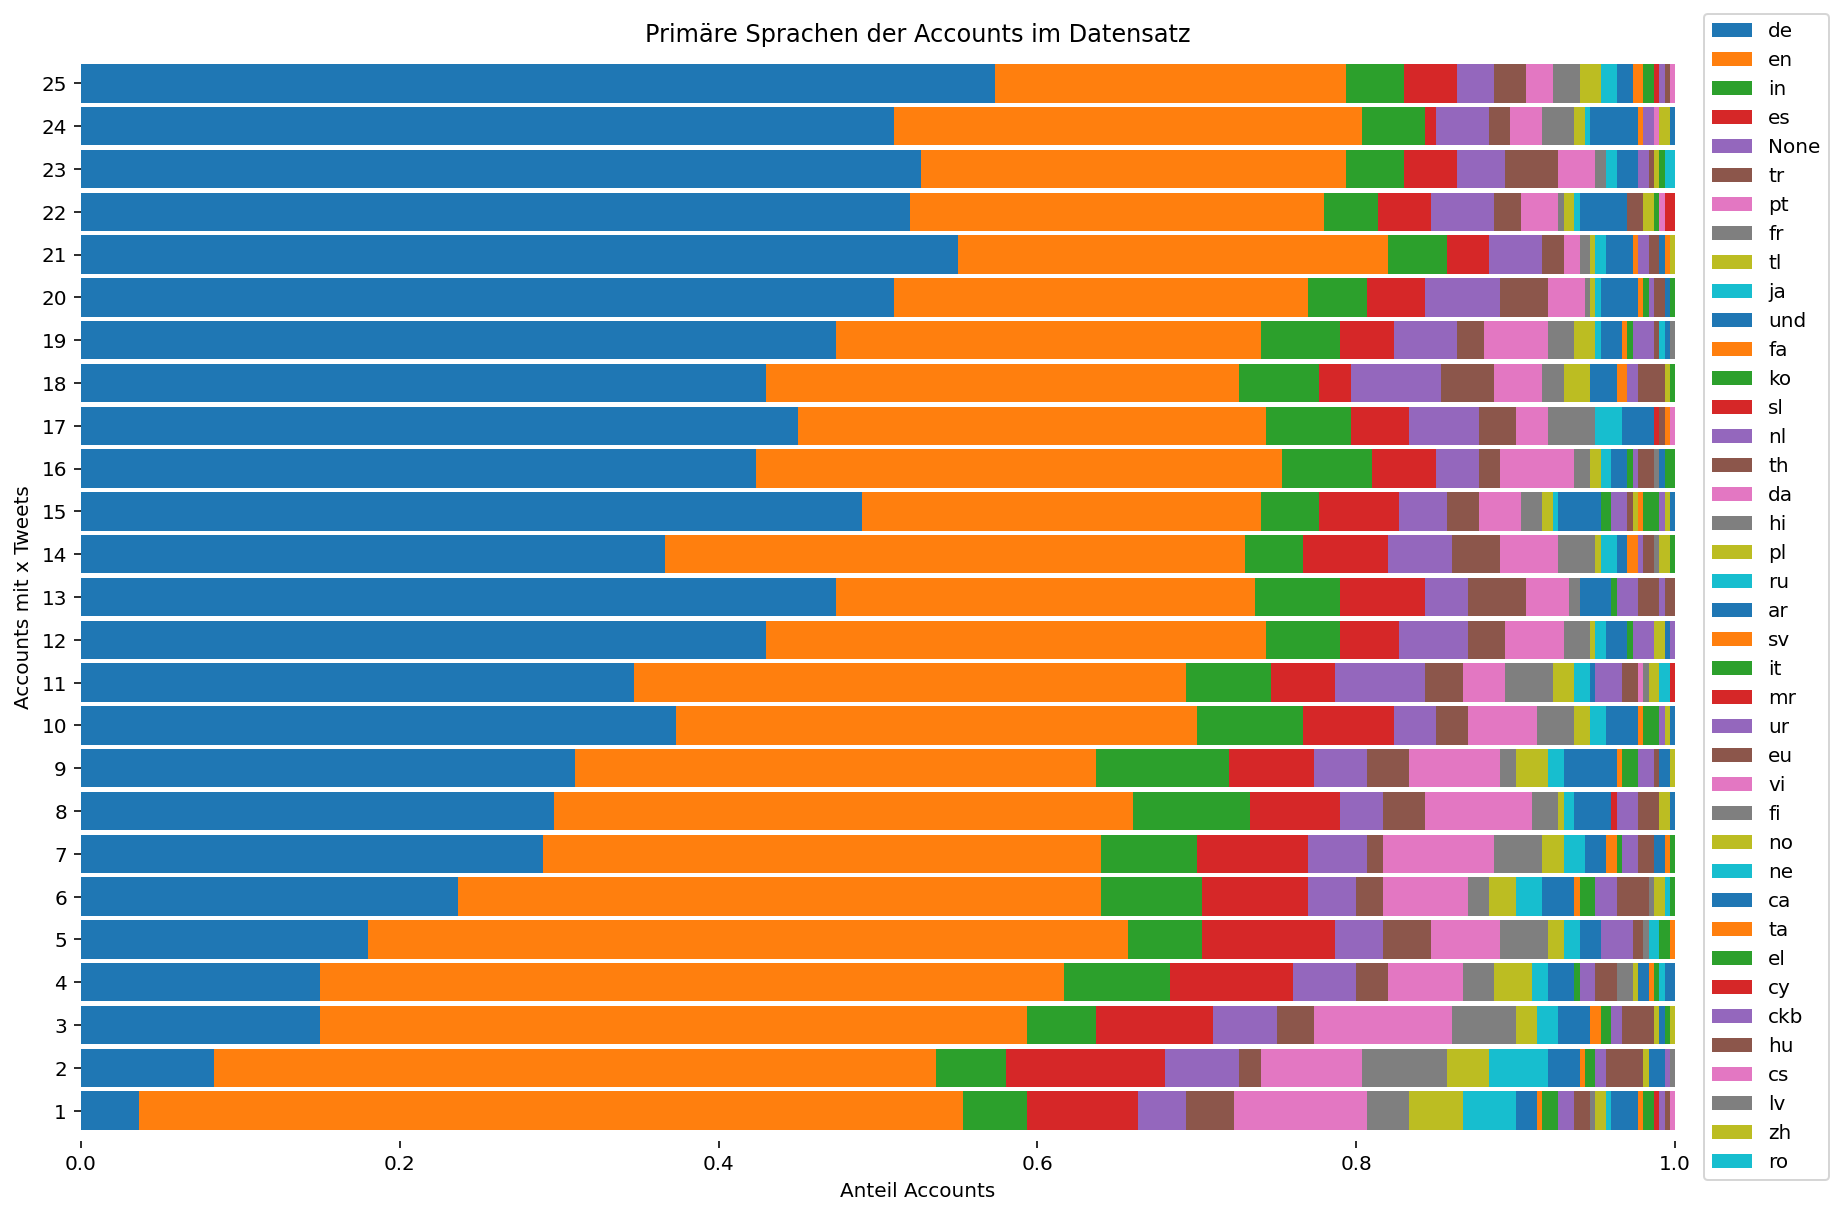

In [47]:
languages_per_tweet = dict()
for i in samples:
    languages_per_tweet[i] = dict(collections.Counter(samples[i]))
    #print(f'{i} Tweets: {collections.Counter(samples[i])}')
    
df_languages = pd.DataFrame(languages_per_tweet).apply(lambda x: x/300).sort_values(by=25, ascending=False).transpose()

chart = df_languages.plot(figsize=(15,10),
                          kind='barh',
                          stacked=True,
                          width=0.9,
                          title = "Primäre Sprachen der Accounts im Datensatz"
                         )
chart.spines["top"].set_visible(False)
chart.spines["right"].set_visible(False)
chart.spines["bottom"].set_visible(False)
chart.spines["left"].set_visible(False)
chart.legend(loc='right', bbox_to_anchor=(1.05,0.5))
chart.set(ylabel='Accounts mit x Tweets',
          xlabel='Anteil Accounts')

In [29]:
pd.DataFrame(languages_per_tweet).transpose()#.max().max()

,en,de,es,ja,tr,in,pt,hi,tl,pl,...,el,sl,da,cy,ckb,hu,cs,lv,zh,ro
1,155.0,11.0,21.0,10.0,9.0,12.0,25.0,1.0,10.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,136.0,25.0,30.0,11.0,4.0,13.0,19.0,NaN,8.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,133.0,45.0,22.0,4.0,7.0,13.0,26.0,NaN,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140.0,45.0,23.0,3.0,6.0,20.0,14.0,3.0,7.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,143.0,54.0,25.0,3.0,9.0,14.0,13.0,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,121.0,71.0,20.0,5.0,5.0,19.0,16.0,1.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,105.0,87.0,21.0,4.0,3.0,18.0,21.0,NaN,4.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,109.0,89.0,17.0,2.0,8.0,22.0,20.0,NaN,1.0,2.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,98.0,93.0,16.0,3.0,8.0,25.0,17.0,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,98.0,112.0,17.0,3.0,6.0,20.0,13.0,NaN,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
df_usertweets = pd.DataFrame([df[['user_id', 'study_tweet_counts', 'screen_name']].groupby('user_id').first().groupby('study_tweet_counts').count()['screen_name'],
                              df[['study_tweet_counts', 'user_id']].groupby('study_tweet_counts').count()['user_id']]).rename({'screen_name':'Accounts', 'user_id':'Tweets'}).transpose().reset_index()
df_usertweets

,study_tweet_counts,Accounts,Tweets
0,1,3414563,3414563
1,2,822289,1644578
2,3,360573,1081719
3,4,205194,820776
4,5,132686,663430
...,...,...,...
3079,15945,1,15945
3080,16096,1,16096
3081,26411,1,26411
3082,30089,1,30089


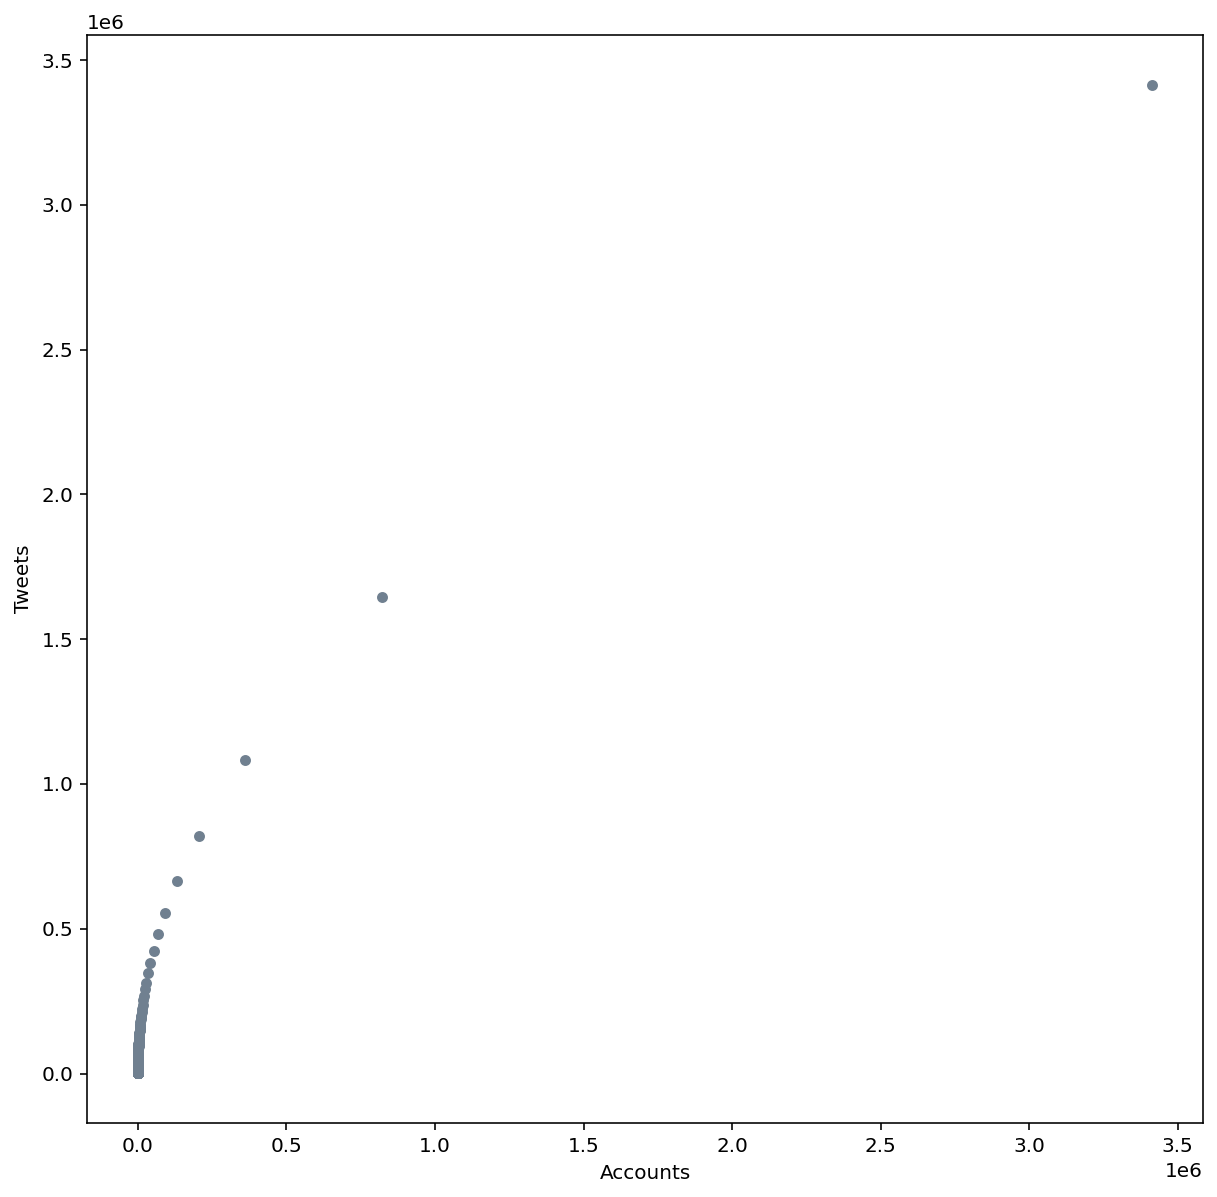

In [151]:
chart = df_usertweets.plot.scatter(
    figsize = (10,10),
    x='Accounts',
    y='Tweets',
    color = 'slategrey',
    title = ''
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x+0.001, 'y': y+0.0005, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], f"{int(point['val'])}")

#label_point(df_usertweets['Accounts'], df_usertweets['Tweets'], df_usertweets['study_tweet_counts'], chart)


# Auswertung Tweets
- Typ: OT, RT, QT, RP


- Tweets pro Tag
- Tweets pro Wochentag
- Tweets pro Tageszeit


- Medien: Video, Gif, Bild,
- Poll


- URLs
- Domains


- Hashtags

In [12]:
# Für die weitere Auswertung nur Tweets von 
# Accounts, die mindestens zweimal im Datensatz sind
df = df[df['study_tweet_counts'] >= 2]

In [13]:
df #46753609

,id,user_id,screen_name,followers_count,friends_count,user_created_at,retweet_count,favorite_count,source,is_quote,is_reply,is_retweet,is_verified,media,study_tweet_counts
created_at,,,,,,,,,,,,,,,
2020-10-04 00:00:00,1312542952980459522,2688924244,mdamby1,113,545,Tue Jul 08 23:35:18 +0000 2014,38,0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,False,True,False,,415
2020-10-04 00:00:00,1312542954972684294,1207983716502515712,SGweyerWetter,4,18,Fri Dec 20 11:21:04 +0000 2019,0,0,"<a href=""http://www.weather-display.com"" rel=""...",False,False,False,False,,669
2020-10-04 00:00:00,1312542953915768832,1211087474824335360,PitBull82251713,45,310,Sun Dec 29 00:52:27 +0000 2019,0,0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,False,False,False,photo,58
2020-10-04 00:00:00,1312542953810857984,1295378597767716868,iaguin_crvg,584,875,Mon Aug 17 15:15:07 +0000 2020,71,0,"<a href=""http://twitter.com/download/android"" ...",False,False,True,False,photo,6
2020-10-04 00:00:00,1312542953290817537,523459447,Schmitz_home,5,0,Tue Mar 13 17:11:17 +0000 2012,0,0,"<a href=""http://schmitz.webhop.net"" rel=""nofol...",False,False,False,False,,2293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04 23:59:59,1324139360346918912,970440742282977282,Krieg7071,3316,0,Sun Mar 04 23:27:57 +0000 2018,0,14,"<a href=""https://github.com/spinfo/autoChirp"" ...",False,False,False,False,,369
2020-11-04 23:59:59,1324139361705877504,1142585317670760448,echtkeinbock,146,132,Sun Jun 23 00:09:02 +0000 2019,0,1,"<a href=""http://twitter.com/download/iphone"" r...",False,True,False,False,,589
2020-11-04 23:59:59,1324139359034101761,1272281680972328961,KammerTaylan,160,397,Sun Jun 14 21:36:28 +0000 2020,90,0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,False,True,False,,154


In [14]:
# Tweets je Tag
print(f"Im Schnitt wurden {df.groupby(pd.Grouper(freq='d'))['id'].count().mean():,} Tweets pro Tag veröffentlicht.\n"
     f"Median: {df.groupby(pd.Grouper(freq='d'))['id'].count().median():,}\n"
     f"Max: {df.groupby(pd.Grouper(freq='d'))['id'].count().max():,}\n"
     f"Min: {df.groupby(pd.Grouper(freq='d'))['id'].count().min():,}\n")
df.groupby(pd.Grouper(freq='d'))['id'].count()

Im Schnitt wurden 1,461,050.28125 Tweets pro Tag veröffentlicht.
Median: 1,449,423.0
Max: 1,627,821
Min: 1,315,483



created_at
2020-10-04    1315483
2020-10-05    1410125
2020-10-06    1401515
2020-10-07    1447032
2020-10-08    1462786
2020-10-09    1462349
2020-10-10    1381757
2020-10-11    1395309
2020-10-12    1441372
2020-10-13    1448434
2020-10-14    1481210
2020-10-15    1442275
2020-10-16    1473482
2020-10-17    1430890
2020-10-18    1450412
2020-10-19    1496137
2020-10-20    1518461
2020-10-21    1486077
2020-10-22    1462473
2020-10-23    1462282
2020-10-24    1360580
2020-10-25    1435409
2020-10-26    1434980
2020-10-27    1437954
2020-10-28    1602252
2020-10-29    1537549
2020-10-30    1532479
2020-10-31    1408784
2020-11-01    1393305
2020-11-02    1560220
2020-11-03    1627821
2020-11-04    1552415
Freq: D, Name: id, dtype: int64

In [15]:
def tweetfreq(df_local, title, timeperiod='h', color='slategrey'):
    df_timeperiod = df_local.groupby(pd.Grouper(freq=timeperiod))['id'].count()
    df_timeperiod.index.name = 'Zeit (UTC)'
    fig = plt.figure(
        figsize=(17, 8),
        facecolor='1')
    plt.ylabel ('Tweets je ' + str(timeperiod))
    ax = df_timeperiod.plot(title=title, color=color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(ymin=0)

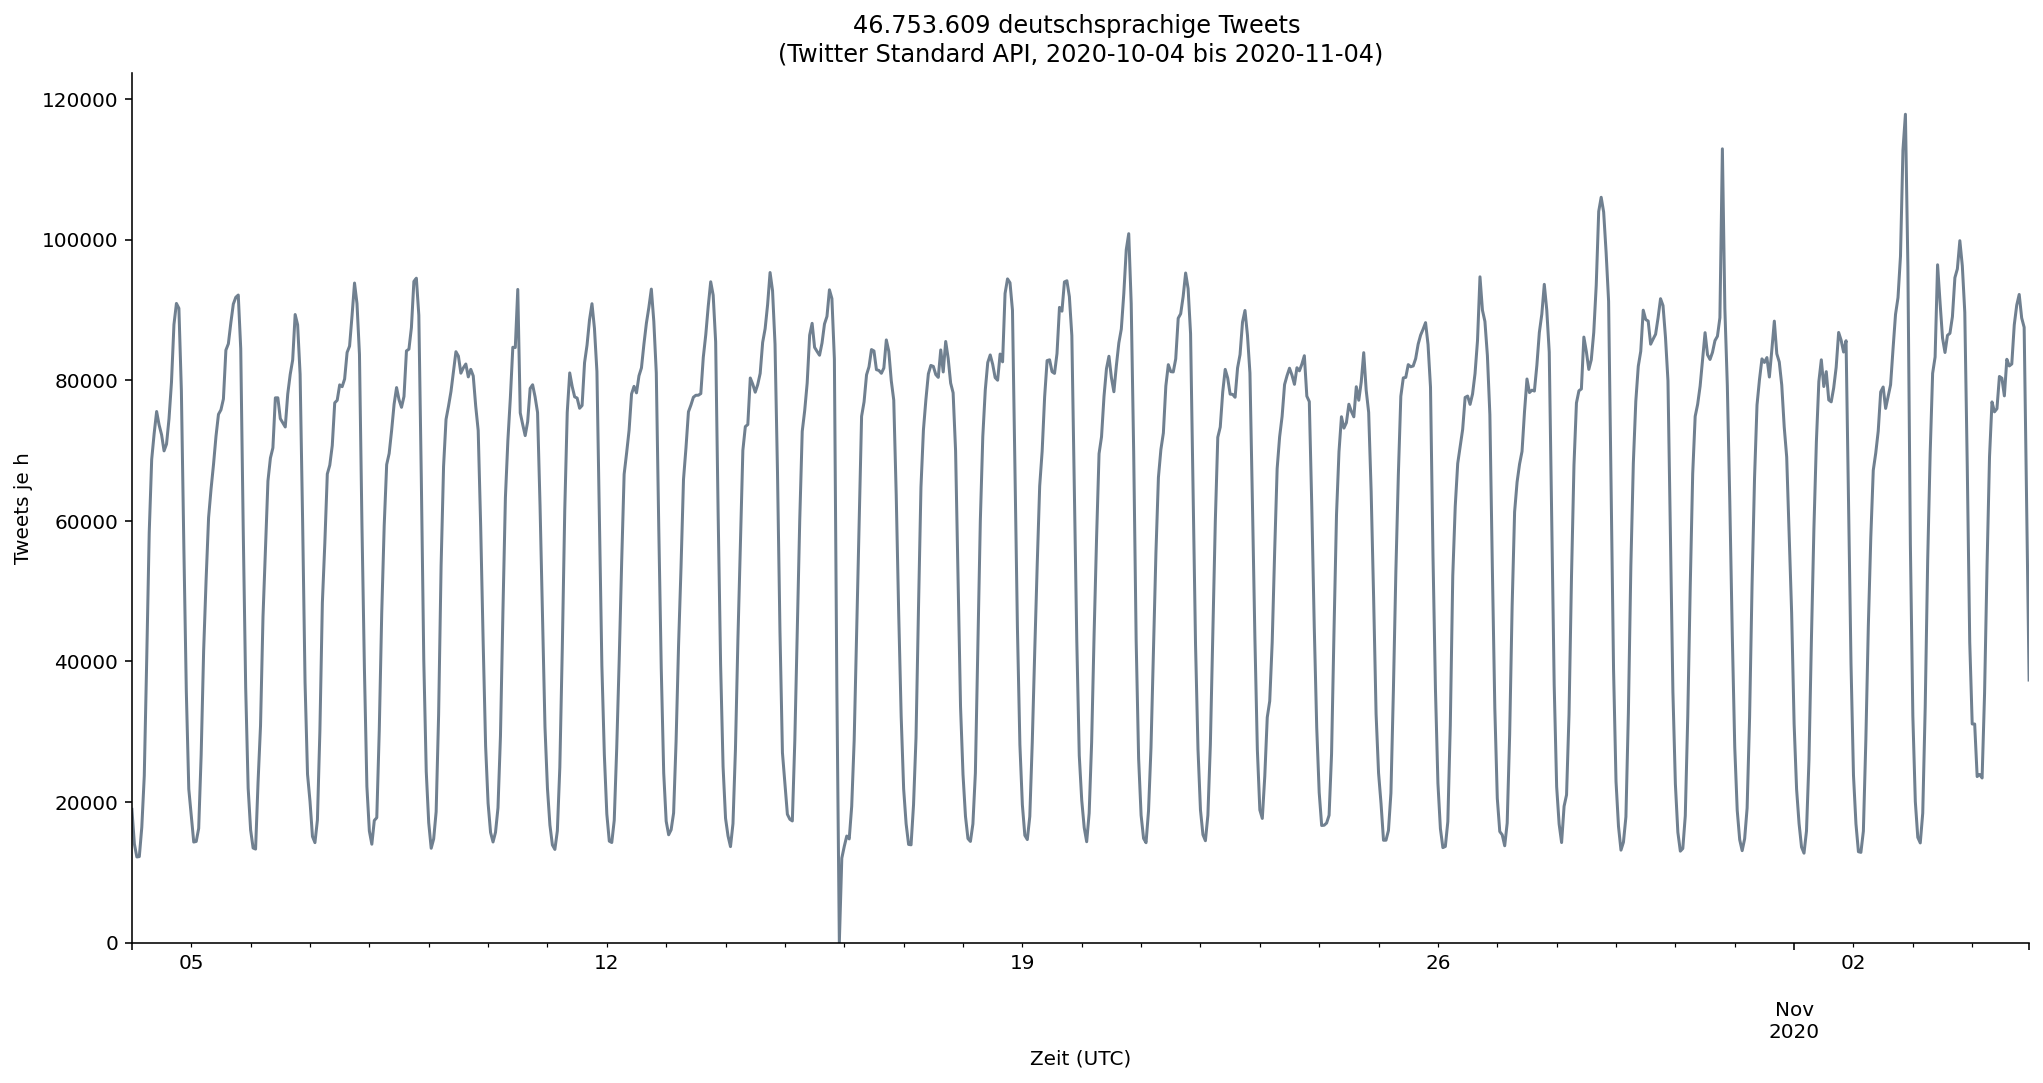

In [16]:
tweet_anzahl = f"{len(df):,}".replace(",",".")
tweetfreq(
    df, 
    f'{tweet_anzahl} deutschsprachige Tweets \n(Twitter Standard API, 2020-10-04 bis 2020-11-04)',
    timeperiod='h'
)

In [21]:
temp = df.resample('1d').count()
temp.groupby(temp.index.day_name())['id'].mean().sort_values()

created_at
Friday       1482648.00
Monday       1468566.80
Saturday     1395502.75
Sunday       1397983.60
Thursday     1476270.75
Tuesday      1486837.00
Wednesday    1513797.20
Name: id, dtype: float64

In [27]:
temp['id'].mean()

1461050.28125

In [26]:
temp.groupby(temp.index.day_name())['id'].mean().sort_values()

created_at
Saturday     1395502.75
Sunday       1397983.60
Monday       1468566.80
Thursday     1476270.75
Friday       1482648.00
Tuesday      1486837.00
Wednesday    1513797.20
Name: id, dtype: float64

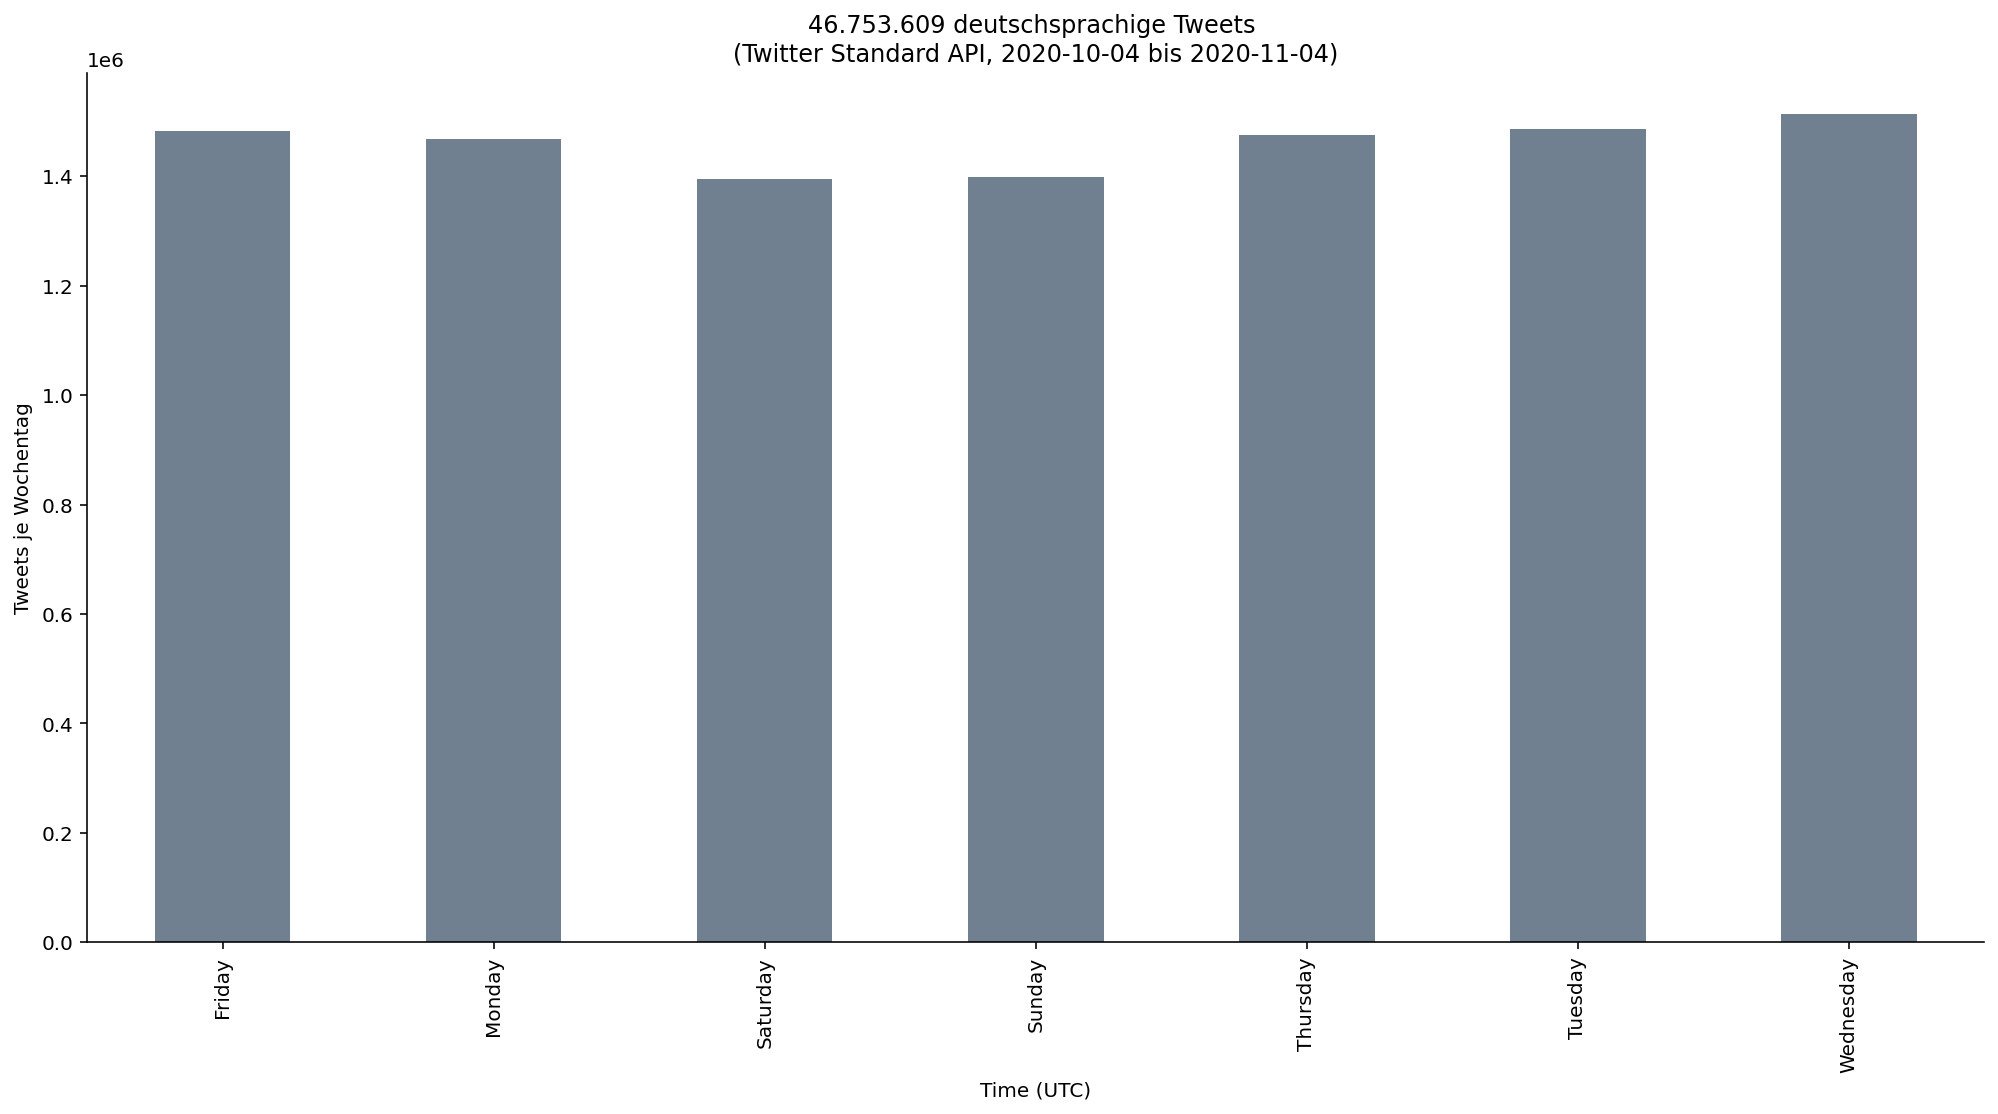

In [23]:
tweet_anzahl = f"{len(df):,}".replace(",",".")
def weekday_freq(df_local, title, color='slategrey'):
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df_local = df_local.resample('1d').count()
    df_timeperiod = df_local.groupby(df_local.index.day_name())['id'].mean()#.reindex(cats) 
    df_timeperiod.index.name = 'Time (UTC)'
    fig = plt.figure(
        figsize=(17, 8),
        facecolor='1')
    plt.ylabel ('Tweets je Wochentag')
    ax = df_timeperiod.plot(title=title, color=color, kind='bar')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(ymin=0)

weekday_freq(
    df, 
    f'{tweet_anzahl} deutschsprachige Tweets \n(Twitter Standard API, 2020-10-04 bis 2020-11-04)',
)

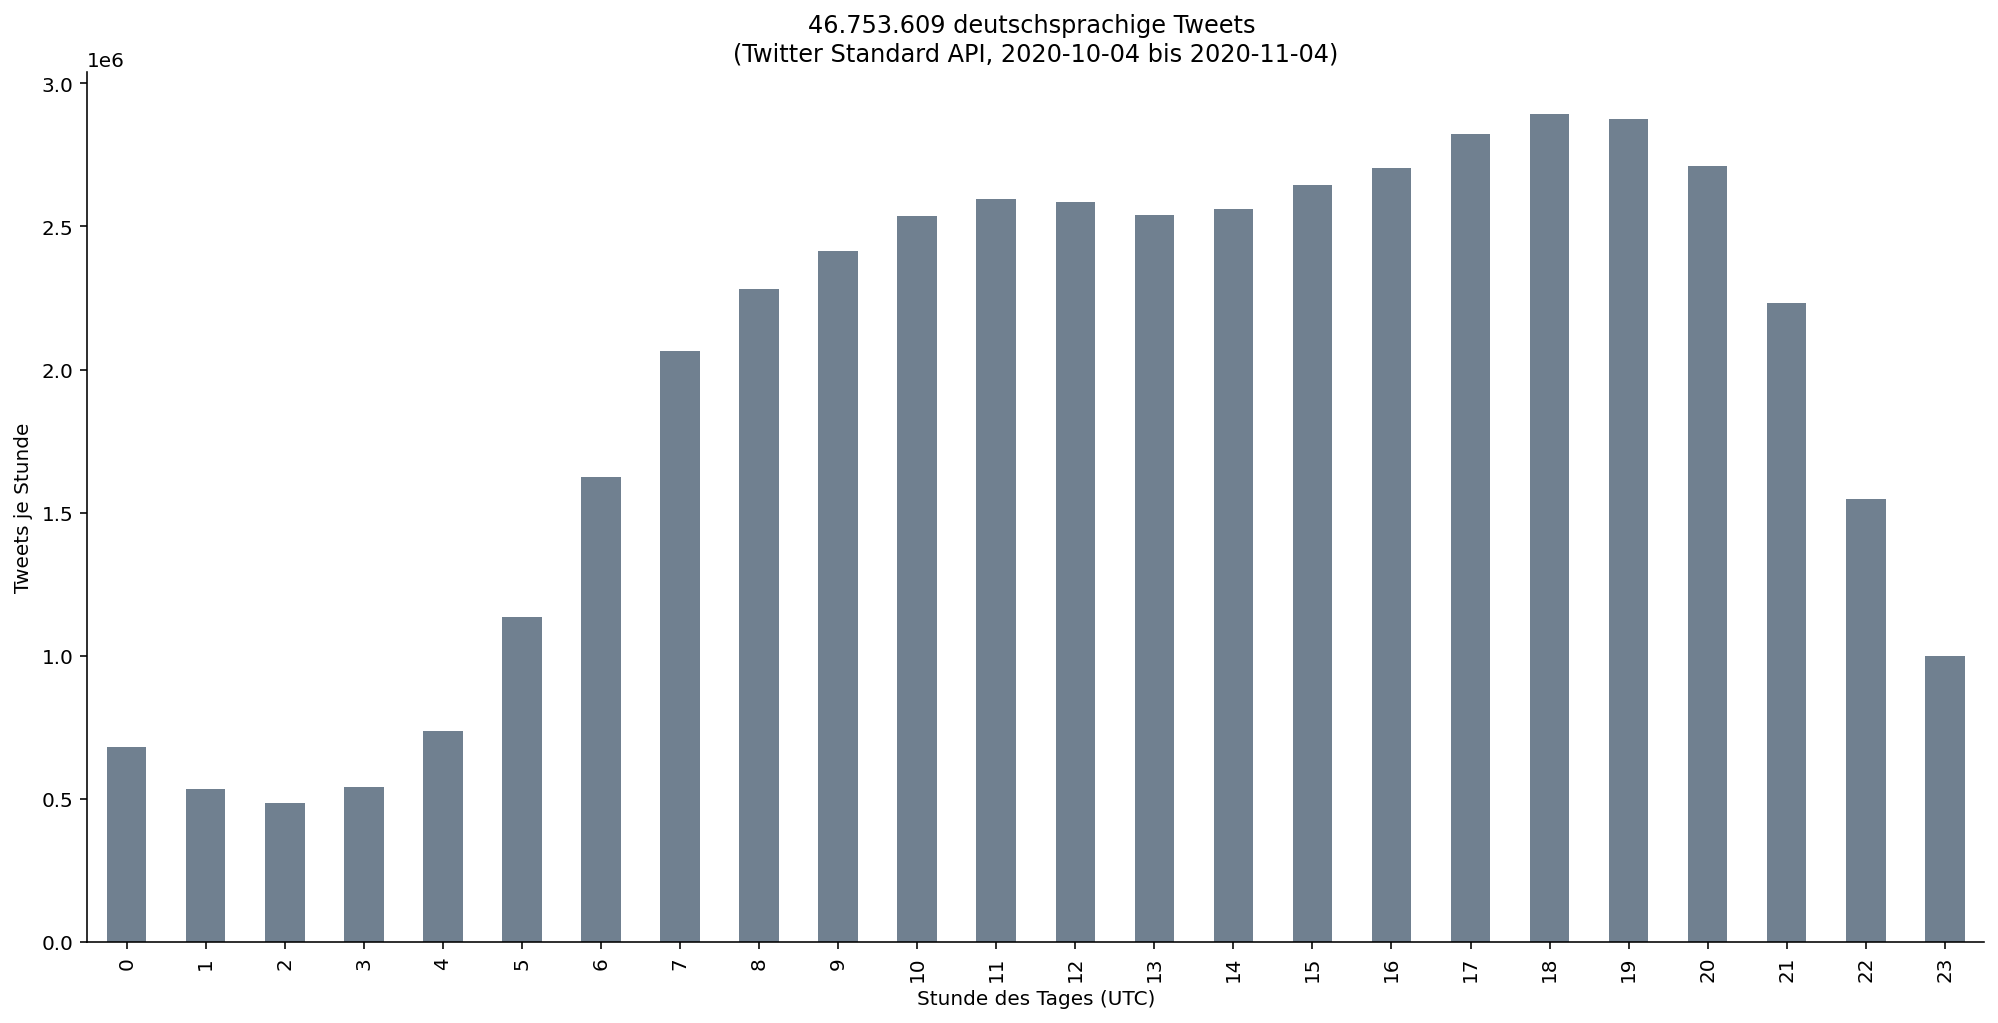

In [216]:
tweet_anzahl = f"{len(df):,}".replace(",",".")
def hour_freq(df_local, title, color='slategrey'):
    df_timeperiod = df_local.groupby(df_local.index.hour)['id'].count()
    df_timeperiod.index.name = 'Stunde des Tages (UTC)'
    fig = plt.figure(
        figsize=(17, 8),
        facecolor='1')
    plt.ylabel ('Tweets je Stunde')
    ax = df_timeperiod.plot(title=title, color=color, kind='bar')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(ymin=0)

hour_freq(
    df, 
    f'{tweet_anzahl} deutschsprachige Tweets \n(Twitter Standard API, 2020-10-04 bis 2020-11-04)',
)

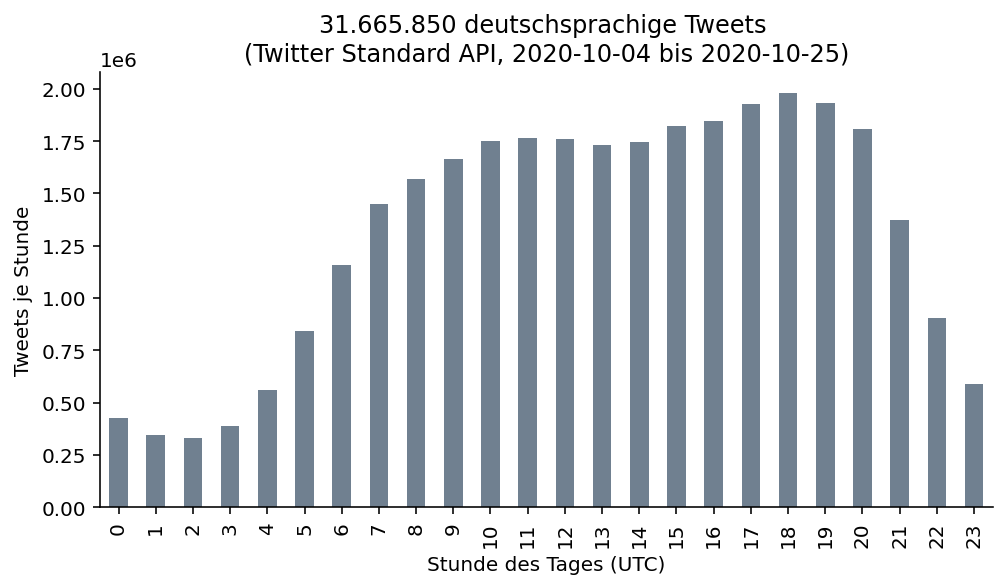

In [224]:
tweet_anzahl = f"{len(df[:'2020-10-25']):,}".replace(",",".")
def hour_freq(df_local, title, color='slategrey'):
    df_timeperiod = df_local.groupby(df_local.index.hour)['id'].count()
    df_timeperiod.index.name = 'Stunde des Tages (UTC)'
    fig = plt.figure(
        figsize=(8, 4),
        facecolor='1')
    plt.ylabel ('Tweets je Stunde')
    ax = df_timeperiod.plot(title=title, color=color, kind='bar')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(ymin=0)

hour_freq(
    df[:'2020-10-25'], 
    f'{tweet_anzahl} deutschsprachige Tweets \n(Twitter Standard API, 2020-10-04 bis 2020-10-25)',
)

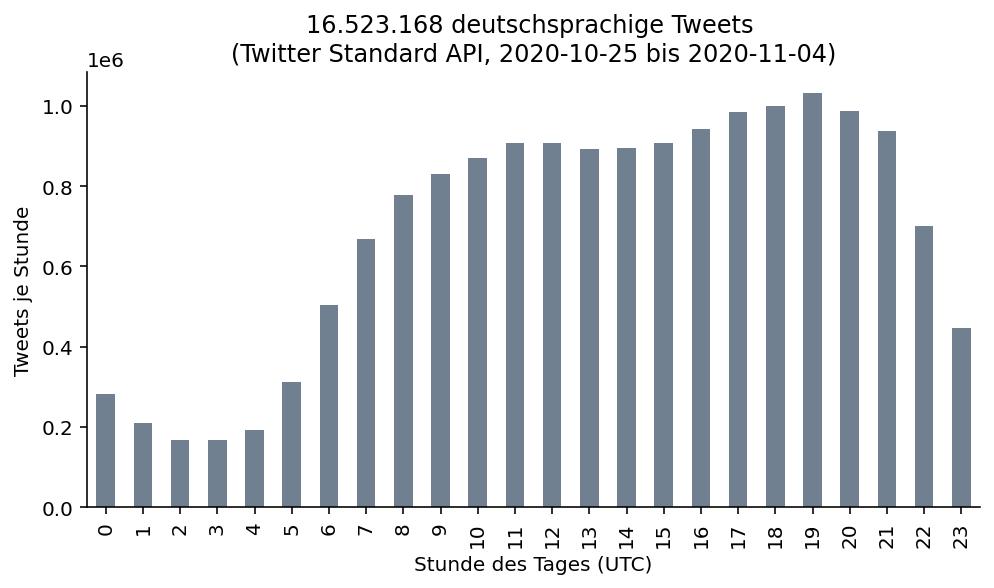

In [222]:
tweet_anzahl = f"{len(df['2020-10-25':]):,}".replace(",",".")
def hour_freq(df_local, title, color='slategrey'):
    df_timeperiod = df_local.groupby(df_local.index.hour)['id'].count()
    df_timeperiod.index.name = 'Stunde des Tages (UTC)'
    fig = plt.figure(
        figsize=(8, 4),
        facecolor='1')
    plt.ylabel ('Tweets je Stunde')
    ax = df_timeperiod.plot(title=title, color=color, kind='bar')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(ymin=0)

hour_freq(
    df['2020-10-25':], 
    f'{tweet_anzahl} deutschsprachige Tweets \n(Twitter Standard API, 2020-10-25 bis 2020-11-04)',
)

In [258]:
total_tweets = len(df)
retweet_count = df[df['is_retweet'] & ~df['is_quote']]['id'].count()
quote_count = df[df['is_quote'] & ~df['is_retweet']]['id'].count()
reply_count = df[df['is_reply'] & ~df['is_quote']]['id'].count()
verified_count = df[df['is_verified']]['id'].count()
other_count = len(df[~df['is_quote'] & ~df['is_reply'] & ~df['is_retweet']])

print(
    f'{retweet_count:,} Retweets: {(retweet_count/total_tweets):.2%}\n',
    f'{quote_count:,} Quote-Tweets: {(quote_count/total_tweets):.2%}\n',
    f'{reply_count:,} Replies: {(reply_count/total_tweets):.2%}\n'
    f'{other_count:,} Other Tweets: {(other_count/total_tweets):.2%}\n'
    f'{verified_count:,} by verified Accounts: {(verified_count/total_tweets):.2%}\n'
)

11,863,188 Retweets: 25.37%
 1,832,605 Quote-Tweets: 3.92%
 22,913,755 Replies: 49.01%
8,808,300 Other Tweets: 18.84%
693,669 by verified Accounts: 1.48%



/home/luca/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Text(2020-10-20 00:00:00, 0.16, ' Umstellung')

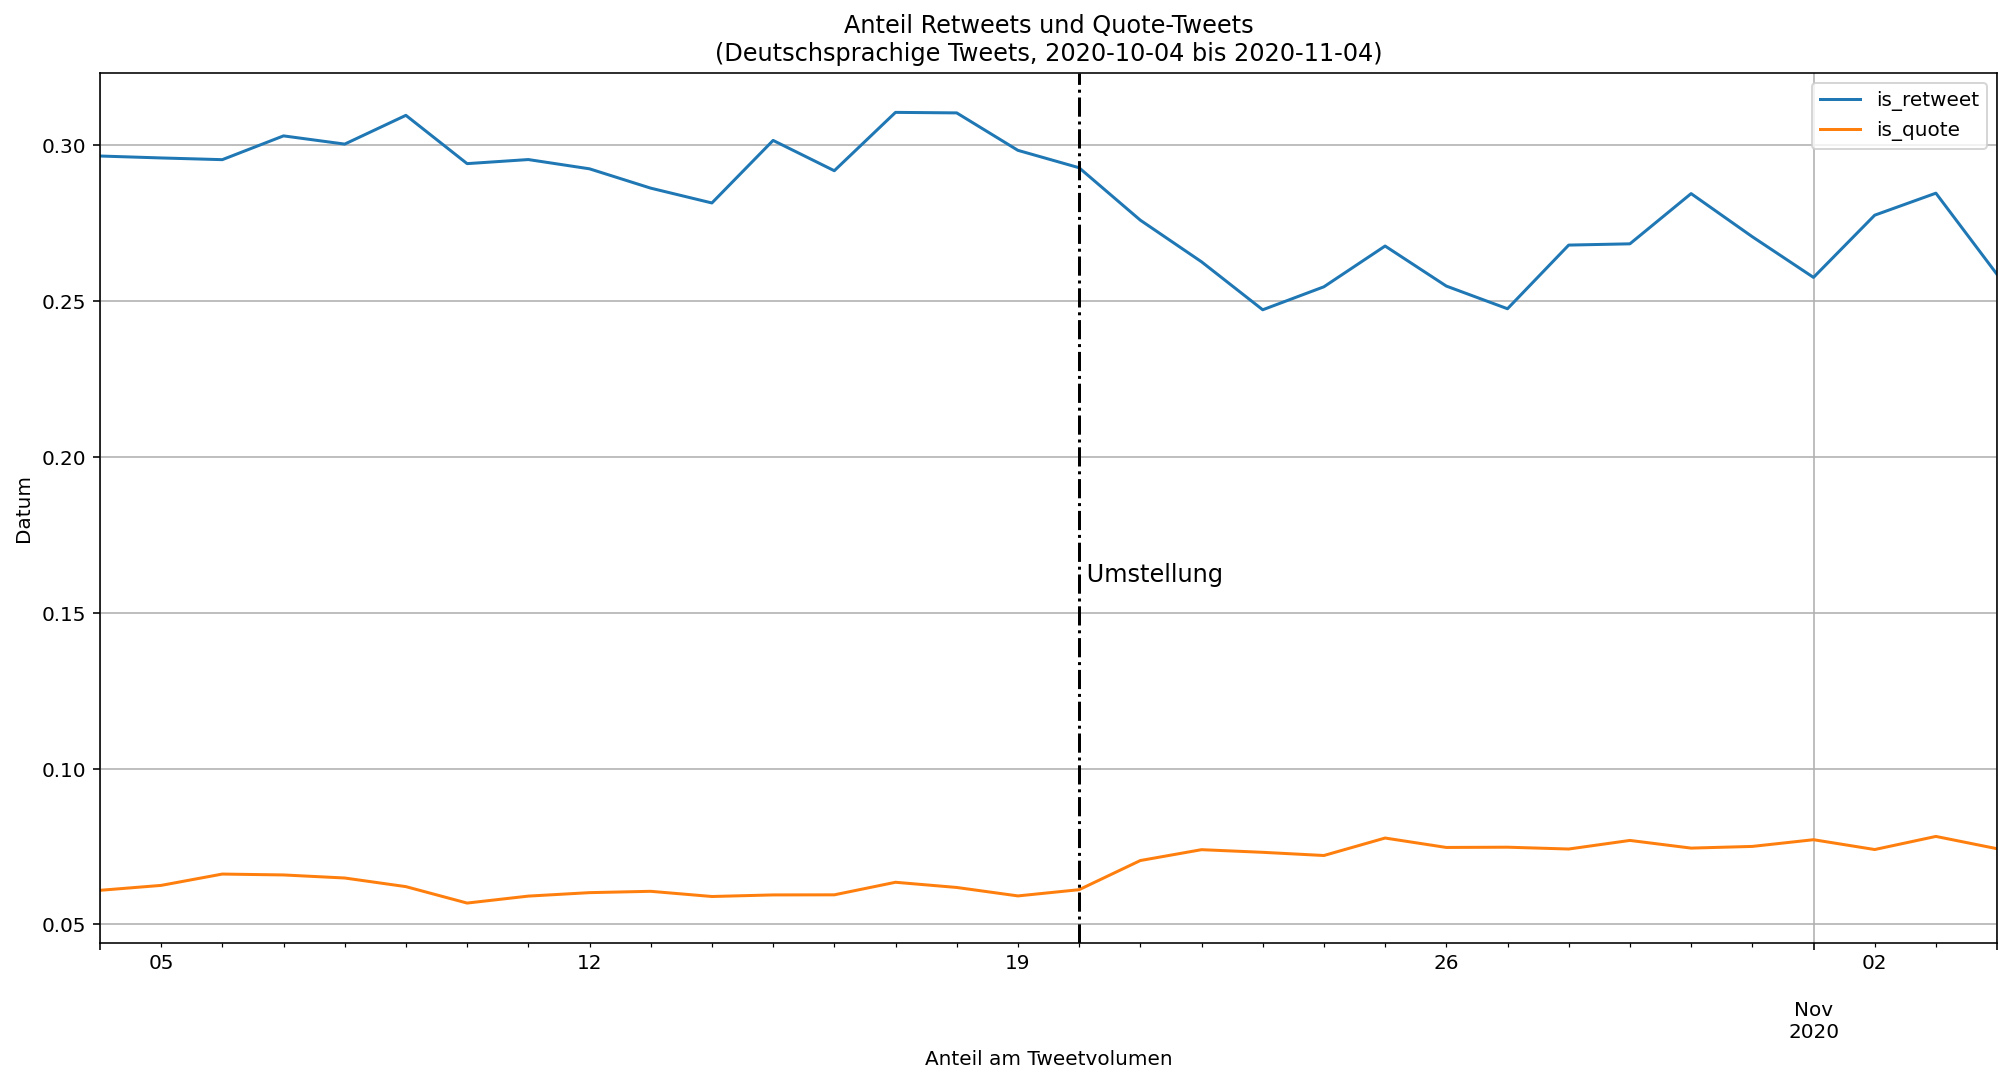

In [310]:
df_rq = df.groupby(pd.Grouper(freq='d'))['is_retweet','is_quote'].sum()
df_rq['is_retweet'] = df_rq['is_retweet']/df.groupby(pd.Grouper(freq='d'))['is_retweet'].count()
df_rq['is_quote'] = df_rq['is_quote']/df.groupby(pd.Grouper(freq='d'))['is_retweet'].count()

chart = df_rq.plot(title="Anteil Retweets und Quote-Tweets\n(Deutschsprachige Tweets, 2020-10-04 bis 2020-11-04)",
                                                                     figsize=(17,8), 
                                                                     grid=True)
chart.set_xlabel("Anteil am Tweetvolumen")
chart.set_ylabel("Datum")
chart.axvline(pd.Timestamp('2020-10-20'),color='black',linestyle='-.')
chart.text(pd.Timestamp('2020-10-20'), 0.16, ' Umstellung', fontsize=12)

In [320]:
df_rq['is_retweet'].apply(lambda x: f"{x:.1%}")

created_at
2020-10-04    29.7%
2020-10-05    29.6%
2020-10-06    29.5%
2020-10-07    30.3%
2020-10-08    30.0%
2020-10-09    31.0%
2020-10-10    29.4%
2020-10-11    29.5%
2020-10-12    29.2%
2020-10-13    28.6%
2020-10-14    28.2%
2020-10-15    30.2%
2020-10-16    29.2%
2020-10-17    31.1%
2020-10-18    31.0%
2020-10-19    29.8%
2020-10-20    29.3%
2020-10-21    27.6%
2020-10-22    26.3%
2020-10-23    24.7%
2020-10-24    25.5%
2020-10-25    26.8%
2020-10-26    25.5%
2020-10-27    24.8%
2020-10-28    26.8%
2020-10-29    26.8%
2020-10-30    28.5%
2020-10-31    27.1%
2020-11-01    25.8%
2020-11-02    27.8%
2020-11-03    28.5%
2020-11-04    25.9%
Freq: D, Name: is_retweet, dtype: object

In [327]:
df[['source', 'id']].groupby('source').count().sort_values(by='id', ascending=False).head(40)

,id
source,
"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",18060966
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",12571379
"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",11335468
"<a href=""http://twitter.com/#!/download/ipad"" rel=""nofollow"">Twitter for iPad</a>",1159436
"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",693483
"<a href=""http://tapbots.com/tweetbot"" rel=""nofollow"">Tweetbot for iΟS</a>",182452
"<a href=""https://ifttt.com"" rel=""nofollow"">IFTTT</a>",168567
"<a href=""https://dlvrit.com/"" rel=""nofollow"">dlvr.it</a>",154920
"<a href=""http://twittbot.net/"" rel=""nofollow"">twittbot.net</a>",115218


In [328]:
# Beliebsteste Apps der verifizierten User
df[df['is_verified']==True].groupby('source').count().sort_values(by='id', ascending=False)['id'][0:20]

source
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                             160055
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>                  143882
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>                  91863
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>                 45037
<a href="https://www.echobox.com" rel="nofollow">Echobox</a>                                         32336
<a href="https://zapier.com/" rel="nofollow">Zapier.com</a>                                          23849
<a href="https://swat.io/" rel="nofollow">Swat.io</a>                                                20365
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>                    14101
<a href="https://dlvrit.com/" rel="nofollow">dlvr.it</a>                                             12809
<a href="http://www.faz.net" r

In [329]:
# Medientypen
df[['id','media']].groupby('media').count().sort_values(by='id')

,id
media,
animated_gif,498472
video,661989
photo,4324936
,41268212


# Accounts

In [15]:
df_accounts = df[['user_id',
                  'screen_name',
                  'followers_count',
                  'friends_count',
                  'user_created_at',
                  'is_verified',
                  'study_tweet_counts'
                 ]].groupby('user_id').first().reset_index()
df_accounts = df_accounts[df_accounts['study_tweet_counts'] >= 2]
df_accounts['user_created_at'] = pd.to_datetime(df_accounts['user_created_at'], format="%a %b %d %H:%M:%S %z %Y").dt.tz_convert("UTC").dt.tz_localize(None)
df_accounts = df_accounts.set_index('user_created_at')
df_accounts

,user_id,screen_name,followers_count,friends_count,user_created_at,is_verified,study_tweet_counts
0,59,Tim535353,8529,2796,2006-04-01 03:31:30,True,1
1,224,davepell,57085,881,2006-05-01 22:17:42,True,1
2,291,goldman,960855,416,2006-05-20 19:46:03,True,2
3,354,iamabot,266,385,2006-06-21 21:22:40,False,1
4,528,buzz,15174,1487,2006-07-12 23:14:49,False,1
...,...,...,...,...,...,...,...
5633974,1324135084740513793,EditKeyboard,0,1,2020-11-04 23:43:07,False,1
5633975,1324135878936170499,Merve00115,0,5,2020-11-04 23:46:18,False,1
5633976,1324135946858553344,xncry,25,44,2020-11-04 23:46:46,False,1
5633977,1324137519936544768,Fernand80673511,0,3,2020-11-04 23:52:57,False,1


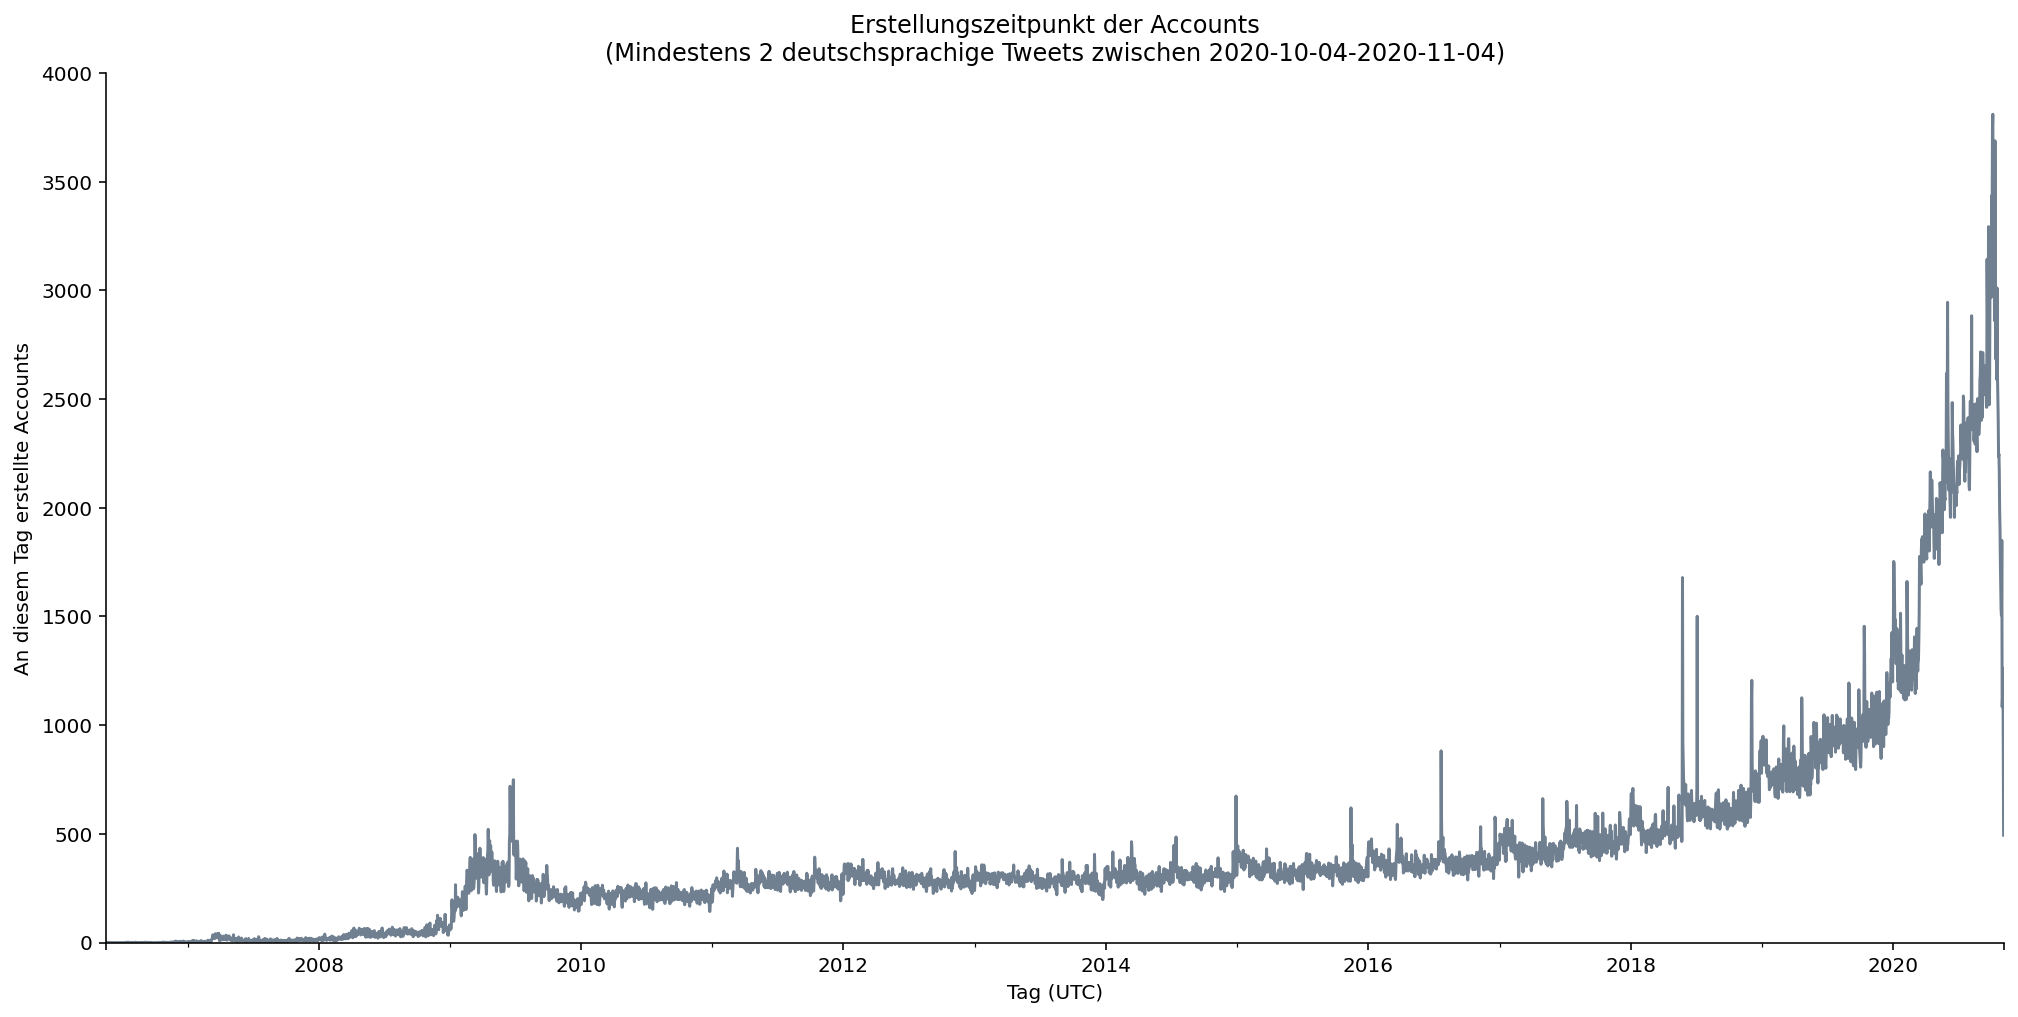

In [24]:
def plot_account_age(df_local, timeperiod, title, color='slategrey'):
    df_timeperiod = df_local.groupby(pd.Grouper(freq=timeperiod))['user_id'].count()
    df_timeperiod.index.name = 'Tag (UTC)'
    fig = plt.figure(
        figsize=(17, 8),
        facecolor='1')
    plt.ylabel ('An diesem Tag erstellte Accounts')
    ax = df_timeperiod.plot(title=title, color=color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(ymin=0)

plot_account_age(df_accounts.sort_index()['2004':'2021'],
                 '1 d',
                 'Erstellungszeitpunkt der Accounts\n(Mindestens 2 deutschsprachige Tweets zwischen 2020-10-04-2020-11-04)')

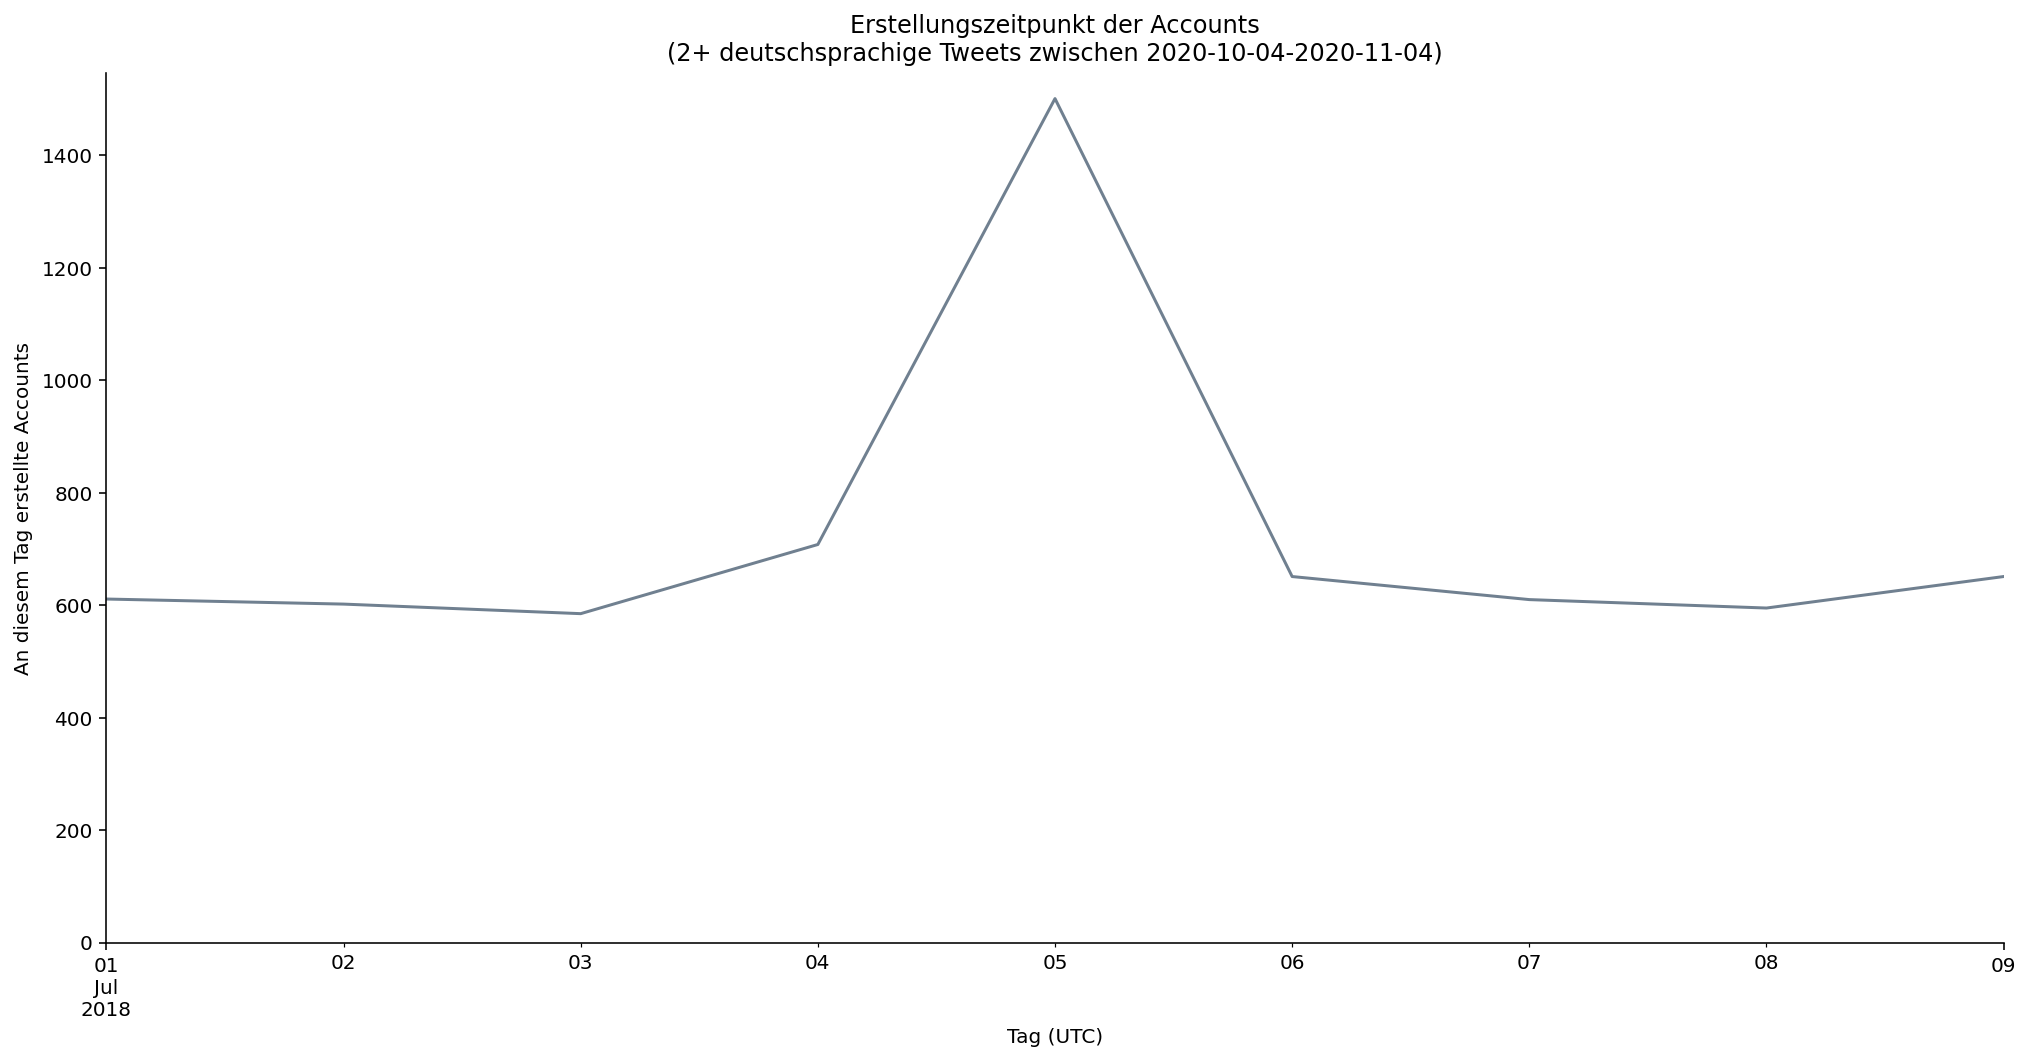

In [138]:
plot_account_age(df_accounts.sort_index()['2018-07-01':'2018-07-09'],
                 '1 d',
                 'Erstellungszeitpunkt der Accounts\n(2+ deutschsprachige Tweets zwischen 2020-10-04-2020-11-04)')

In [25]:
df_accounts.sort_index()[:'2005']

,user_id,screen_name,followers_count,friends_count,is_verified,study_tweet_counts
user_created_at,,,,,,
1970-01-01,1163801014102663168,jinyoungs_hoe,446,499,False,4
1970-01-01,1189534726928896000,Hen20Kos,0,1,False,4
1970-01-01,1197362131391467521,phanswiftie13,295,453,False,8
1970-01-01,1215054260888653825,ustu_bir,99,347,False,2
1970-01-01,1227666144099737600,oofington,3,37,False,22
1970-01-01,1268957229220233217,rizeyunggawd,60,289,False,3
1970-01-01,1285091030262521859,LucasOliveirani,217,619,False,7
1970-01-01,1295115839784595458,VnioAlmeida2,415,414,False,2
1970-01-01,1313667331432697856,CareBearGalaxy,21,49,False,2


In [108]:
(df_accounts.sort_index()['2005':].reset_index()['user_created_at']-pd.Timestamp('2020-11-04')).mean()

Timedelta('-1401 days +00:38:19.054778')

In [110]:
df_accounts.sort_index()['2005':]

,user_id,screen_name,followers_count,friends_count,is_verified,study_tweet_counts
user_created_at,,,,,,
2006-05-20 19:46:03,291,goldman,960855,416,True,2
2006-07-13 13:52:39,591,Naina,22687,93,True,3
2006-07-14 05:49:14,767,xeni,155087,15313,True,8
2006-07-15 20:33:05,1033,ConroyForReal,9652,664,False,3
2006-07-15 21:12:15,1038,martijn,1602,1154,False,4
...,...,...,...,...,...,...
2020-11-04 23:01:09,1324124393174347776,leondari90,1,10,False,2
2020-11-04 23:06:45,1324125873679798273,JustMyT85173290,0,15,False,2
2020-11-04 23:10:21,1324126831671431169,Insulaner10,0,1,False,3


In [116]:
df_accounts.sort_index()['2020-10-04':]

,user_id,screen_name,followers_count,friends_count,is_verified,study_tweet_counts
user_created_at,,,,,,
2020-10-04 00:00:23,1312542918515798017,MarcoHo07295368,2,116,False,24
2020-10-04 00:00:25,1312543047582973952,porn_click_495,36,0,False,12
2020-10-04 00:01:18,1312543246724354049,sarah_shirwan,105,67,False,6
2020-10-04 00:02:01,1312543371639087105,Aspirione,1,9,False,396
2020-10-04 00:02:02,1312543382346948608,LIBBYRA5,111,156,False,13
...,...,...,...,...,...,...
2020-11-04 23:01:09,1324124393174347776,leondari90,1,10,False,2
2020-11-04 23:06:45,1324125873679798273,JustMyT85173290,0,15,False,2
2020-11-04 23:10:21,1324126831671431169,Insulaner10,0,1,False,3


In [124]:
(df_accounts.sort_index()['2020-01-01':].groupby(pd.Grouper(freq="1 m"))['user_id'].count())/80000

user_created_at
2020-01-31    0.517825
2020-02-29    0.452288
2020-03-31    0.606463
2020-04-30    0.717050
2020-05-31    0.802500
2020-06-30    0.815600
2020-07-31    0.878788
2020-08-31    0.933937
2020-09-30    1.015788
2020-10-31    1.010575
2020-11-30    0.047700
Freq: M, Name: user_id, dtype: float64

# Follow Netzwerk


In [3]:
import networkx as nx

def get_followings(following_id):
    global error_count
    followings = []
    try:
        with open(f'local_data/fdat/{following_id}.f') as f:
            for line in f:
                followings.append(int(line))
    except:
        error_count += 1
        pass
    return (followings)

def create_networkxgraph(account_info, account_ids):
    start_time = time.time()
    
    G = nx.DiGraph()
    relevant_ids = set(account_ids)
    
    nbar = tqdm.tqdm(total=len(account_info), desc="Nodes")
    for i, account in account_info.iterrows():
        nbar.update(1)
        G.add_node(account['user_id'],
            Label = account['screen_name'],
            followers_count = account['followers_count'],
            friends_count = account['friends_count'],
            created_year = account['user_created_at'].year,
            is_verified = account['is_verified'],
            study_tweet_count = account['study_tweet_counts']
        )
    nbar.close()
    
    ebar = tqdm.tqdm(total=len(account_ids), desc="Edges")
    for account in account_ids:
        ebar.update(1)
        local_edges = []
        followings = get_followings(account)
        relevant_followings = list(filter(lambda x: x in relevant_ids, followings))
        for following in relevant_followings:
            local_edges.append((following,account))
        G.add_edges_from(local_edges)
    ebar.close()

    print(f'Created graph with networkX in {(time.time() - start_time)} seconds')
    
    return(G)

In [5]:
df_accounts = df_accounts[df_accounts['study_tweet_counts'] >= 4] #= df_accounts2.copy()

In [ ]:
# Speichern des Dataframes als hdf, um es nicht neu berechnen zu müssen
df_accounts.to_hdf('df_accounts.h5', key='df', mode='w')

In [5]:
# Laden des Dataframes
df_accounts = pd.read_hdf('df_accounts.h5')

In [6]:
start_time = time.time()
relevant_ids = set(df_accounts['user_id'].to_list())
print(f'Aussortiert in {(time.time() - start_time)} Sekunden')

Aussortiert in 0.11041641235351562 Sekunden


In [7]:
len(relevant_ids)

1036554

In [8]:
error_count = 0
start_time = time.time()
networkxgraph = create_networkxgraph(df_accounts.reset_index(), relevant_ids)
print(f'Fehler mit {error_count} Accounts')


Created graph with networkX in 718.1918652057648 seconds
Fehler mit 31838 Accounts


In [9]:
start_time = time.time()
nx.write_graphml(networkxgraph, 'deutschsprachig_min4Tweets_networkx.graphml')
print(f'Saved graph with networkX in {(time.time() - start_time)} seconds')

Saved graph with networkX in 635.586954832077 seconds


# Hashtags
DF rein, Hashtags raus

# URLS
DF rein, Hashtags raus

In [2]:
# Alles Dataframes
[var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
# Memory Usage des dataframes
df_accounts.info()
# Manuelles Ausführen der Garbage Collection
import gc
gc.collect()

[]

# Follow Netzwerk
Berechnung und visuelle Auswertung in Gephi. Vielleicht nochmal mit graph_tool?

- Degrees importieren
- Follower zu Degree
- Followings zu Followers
- 

indegree: Accounts im Netzwerk, die dem Account folgen.

outdegree: Accounts im Netzwerk, denen der Account folgt.

Degree: Verbindungen gesamt

In [4]:
# Laden des Gephi Knoten Exports und Vertauschen von ausgehenden und eingehenden Verbindungen
df_degrees = pd.read_csv('min4deTweets_degrees.csv').rename(columns={'Id':'user_id','outdegree':'indegree','indegree':'outdegree'}).set_index('user_id')

In [5]:
# Laden des Dataframes
df_accounts = pd.read_hdf('df_accounts.h5')
# Reduzieren auf Accounts mit 4 oder mehr Tweets
df_accounts = df_accounts[df_accounts['study_tweet_counts']>=4]

In [6]:
# Kombinieren mit Degrees
df_accounts = df_accounts.join(df_degrees[['indegree','outdegree','Degree']], on='user_id')

In [7]:
df_accounts

,user_id,screen_name,followers_count,friends_count,is_verified,study_tweet_counts,indegree,outdegree,Degree
user_created_at,,,,,,,,,
2006-07-14 05:49:14,767,xeni,155087,15313,True,8,1406,0,1406
2006-07-15 21:12:15,1038,martijn,1602,1154,False,4,57,93,150
2006-07-20 06:24:07,2623,dominik,1330,704,False,14,114,61,175
2006-07-21 15:37:09,2737,jotbe,697,1198,False,256,166,456,622
2006-08-09 14:38:08,3987,Moe,2762,471,False,97,372,236,608
...,...,...,...,...,...,...,...,...,...
2020-11-04 22:09:50,1324111577038180354,ZwergeSieben,0,1,False,4,0,1,1
2020-11-04 22:13:46,1324112302061355011,K93428646,1,66,False,6,0,66,66
2020-11-04 22:37:56,1324118695619272706,yourwor81346717,0,0,False,32,0,0,0


In [15]:
# Statistik
print(
    f"Followers Mean: {df_accounts['followers_count'].mean()}\n",
    f"Followers Median: {df_accounts['followers_count'].median()}\n",
    f"Followings Mean: {df_accounts['friends_count'].mean()}\n",
    f"Followings Median: {df_accounts['friends_count'].median()}\n",
)


Followers Mean: 1955.3707023464287
 Followers Median: 204.0
 Followings Mean: 771.0126303115901
 Followings Median: 290.0



In [41]:
def scatter(df, title='', **kwargs):
    chart = df.plot.scatter(
        title = title + f'\n({len(df):,} Accounts)'.replace(',','.'),
    x = 0,
    y = 1, 
    s = 0.5,
    color = 'slategrey',
    figsize = (15,15),
    **kwargs)
    chart.spines['top'].set_visible(False)
    chart.spines['right'].set_visible(False)
    chart.set_xlim(xmin=0, xmax=int(df.iloc[:, [0]].max()))
    chart.set_ylim(ymin=0, ymax=int(df.iloc[:, [1]].max()))

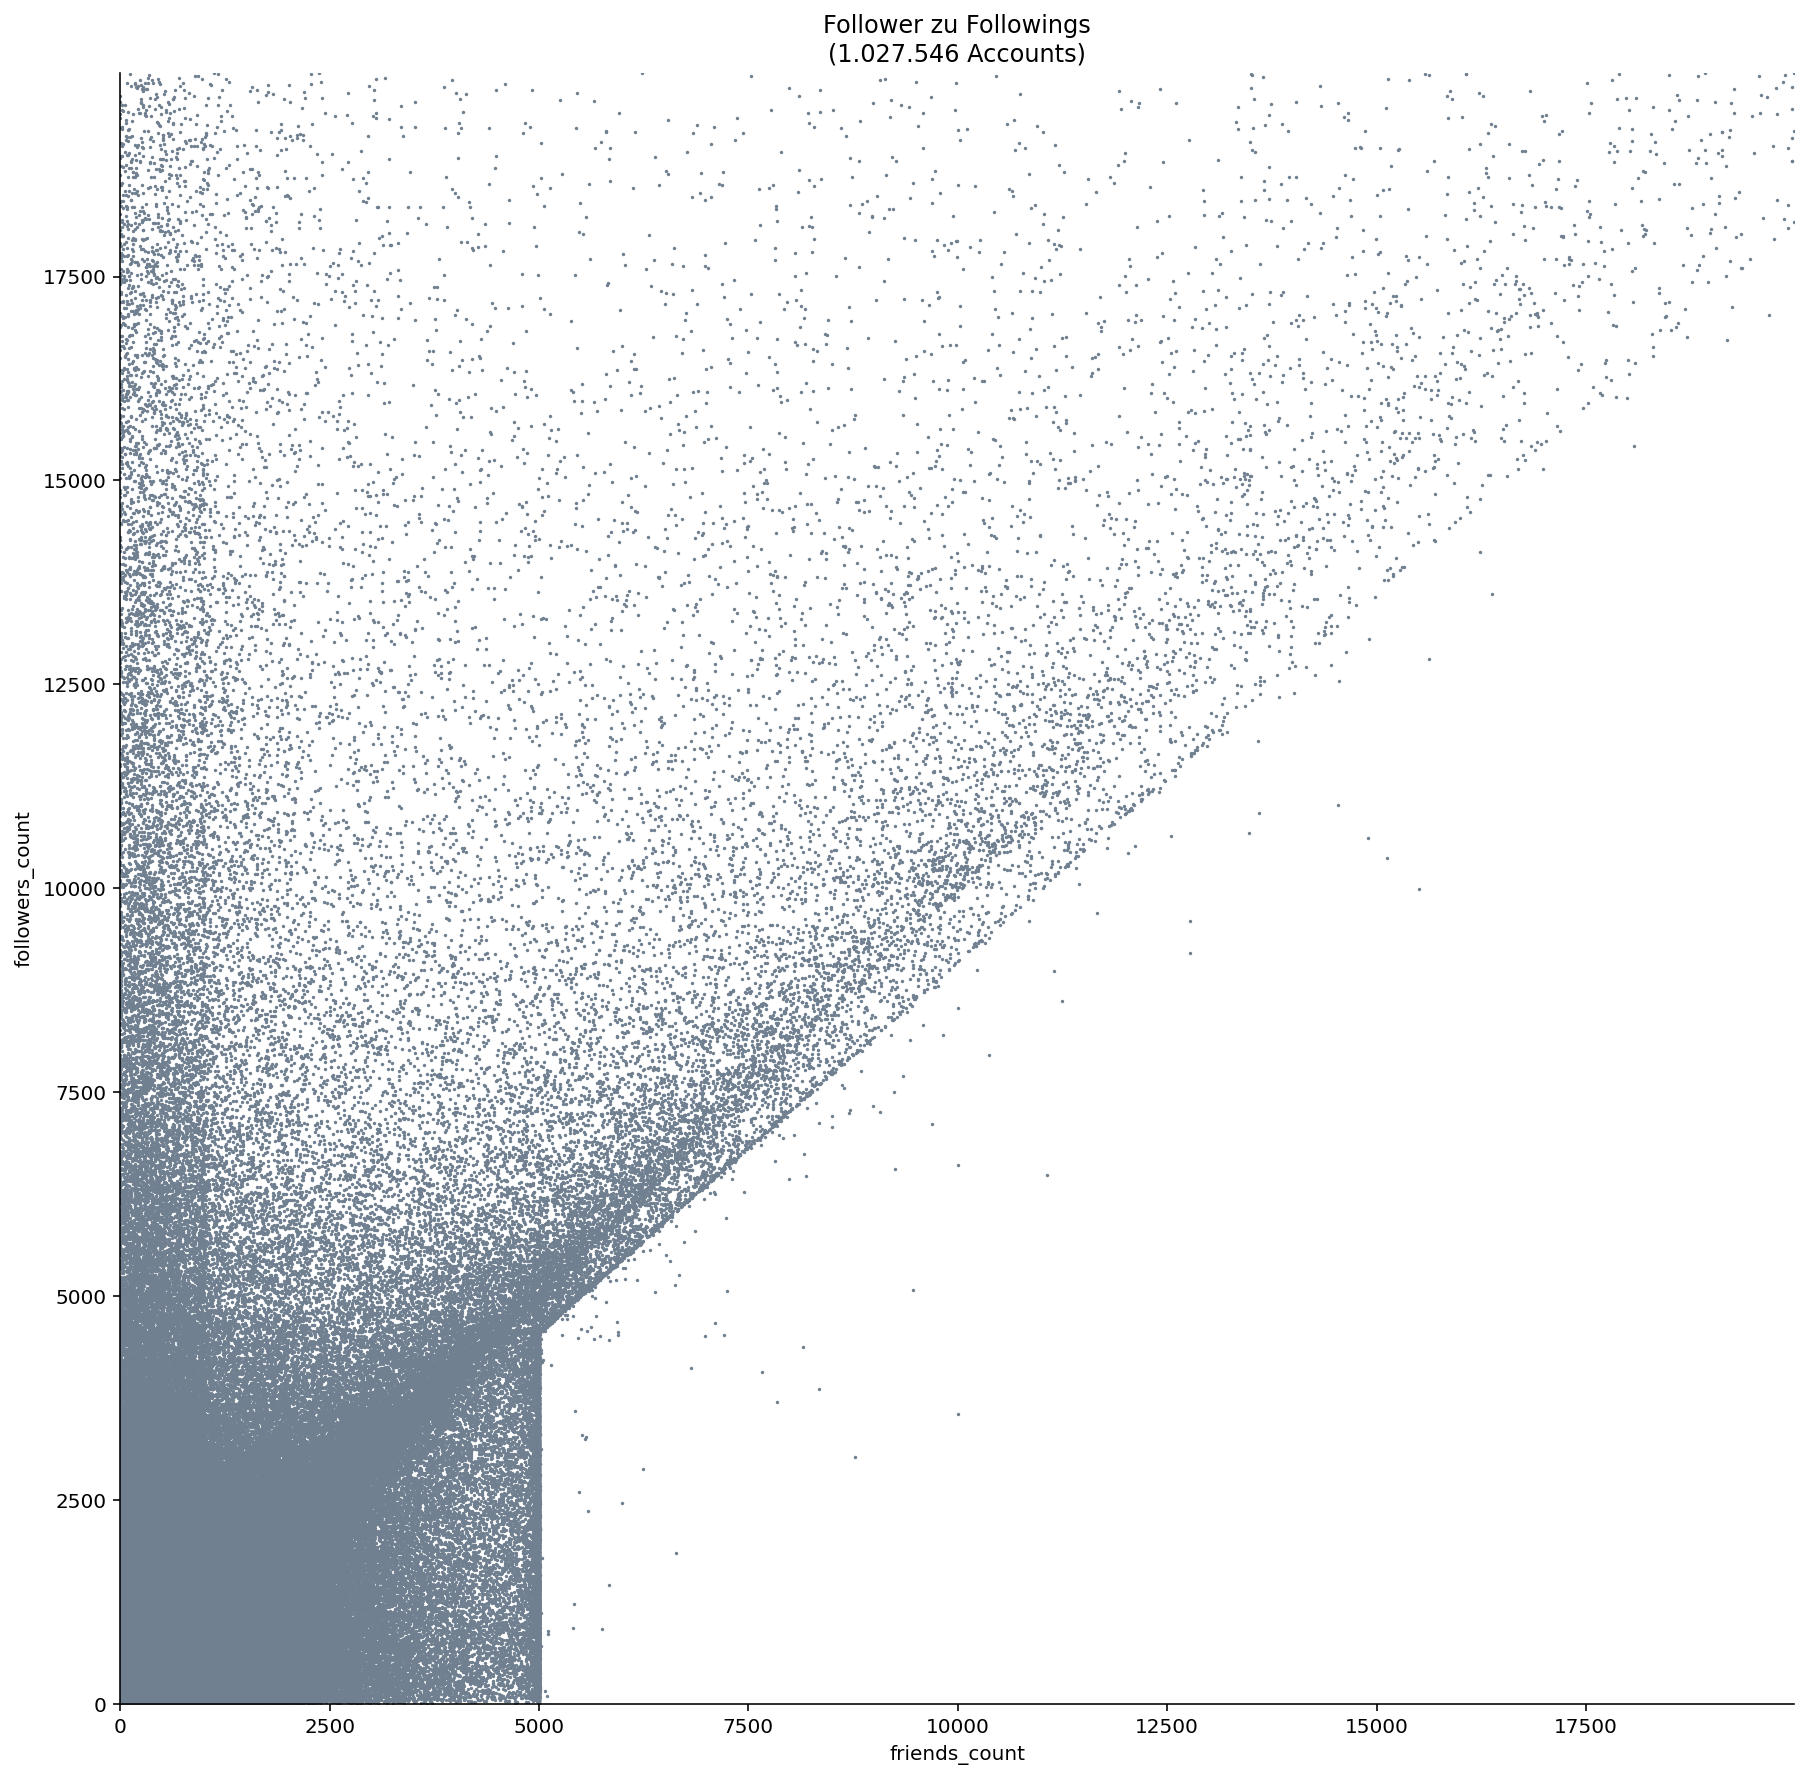

In [17]:
scatter(df_accounts[(df_accounts['friends_count'] <= 20000) & 
                    (df_accounts['followers_count'] <= 20000)].reset_index()[['friends_count','followers_count']],
       title='Follower zu Followings')

In [25]:
df_accounts[(df_accounts['friends_count'] >= 4950) & (df_accounts['friends_count'] <= 5050)]

,user_id,screen_name,followers_count,friends_count,is_verified,study_tweet_counts,indegree,outdegree,Degree
user_created_at,,,,,,,,,
2006-08-22 19:18:05,4602,planspark,3376,5002,False,6,160,0,160
2006-11-22 15:37:44,15383,JahFurry,4149,5001,False,6,25,0,25
2006-12-15 05:55:19,69583,Alheri,3958,5002,False,4,28,0,28
2007-01-23 06:47:35,685063,rtanglao,3232,5001,False,15,15,80,95
2007-02-05 08:47:44,754765,sachaobado,1232,5003,False,4,3,0,3
...,...,...,...,...,...,...,...,...,...
2020-09-05 22:20:05,1302370857067700225,XYZ_MHegirien,136,4999,False,6,5,248,253
2020-09-10 12:30:54,1304034582065491971,xswnju,2236,5002,False,4,152,0,152
2020-09-11 18:15:25,1304483648306122755,ahbebusraaa,5449,5001,False,13,153,0,153


In [39]:
# Searching for Followback spammers
df_accounts[((df_accounts['friends_count'] / df_accounts['followers_count']) >= 0.9) &
            ((df_accounts['friends_count'] / df_accounts['followers_count']) <= 1.1)].sort_values(by='followers_count')

,user_id,screen_name,followers_count,friends_count,is_verified,study_tweet_counts,indegree,outdegree,Degree
user_created_at,,,,,,,,,
2020-11-04 21:30:19,1324101677054570502,awdnkqwwq,1,1,False,30,0,0,0
2020-03-31 20:15:13,1245082156591992832,PeterOneCom,1,1,False,22,0,1,1
2013-09-29 16:44:03,1917606709,SchererKev,1,1,False,5,0,1,1
2020-10-16 12:41:58,1317083307776028685,Nejis_,1,1,False,11,0,1,1
2020-03-30 19:38:51,1244710678922919942,FeralShojo,1,1,False,5,0,0,0
...,...,...,...,...,...,...,...,...,...
2011-04-17 19:06:08,283660297,KavalonThatsMe,356186,353462,False,7,488,0,488
2007-04-05 23:35:02,3568411,BlackHalt,367936,331160,False,6,2260,0,2260
2009-12-28 13:08:48,99943864,Daminous_Purity,375684,407060,False,109,125,0,125


In [40]:
# Anteil wahrscheinlicher Followback-Spammer
131056/len(df_accounts)

0.12643431987142012

In [54]:
df_accounts['indegree'].mean()

115.58688307603849

(0.0, 1000000.0)

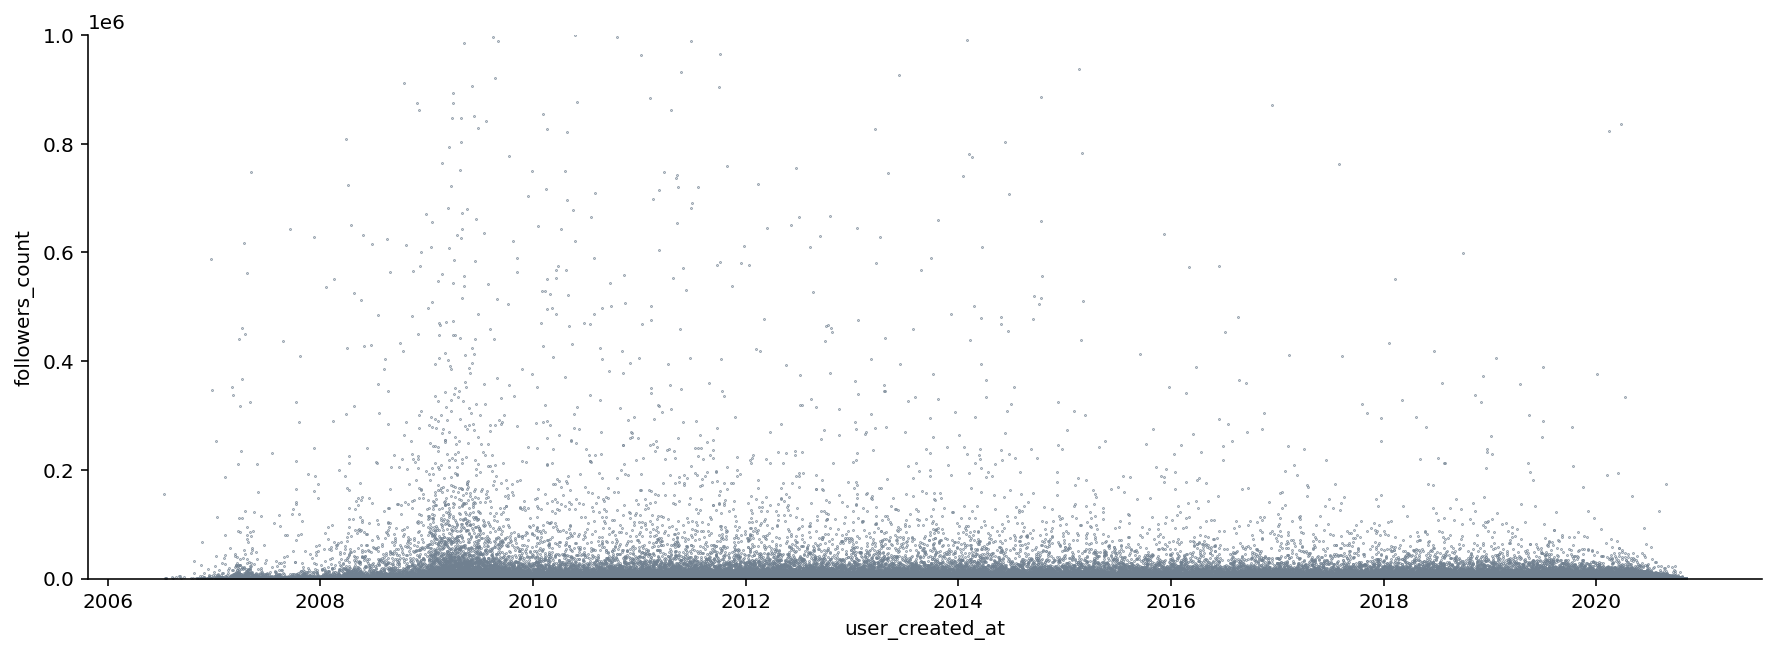

In [111]:
chart = df_accounts['2000':]['followers_count'].to_frame().reset_index().plot.scatter(x='user_created_at',
                                                                                      y='followers_count',
                                                                                      s=0.1,
                                                                                      color = 'slategrey',
                                                                                      figsize = (15,5)
                                                                                     )

chart.spines['top'].set_visible(False)
chart.spines['right'].set_visible(False)
#chart.set_xlim(xmin=0, xmax=int(df.iloc[:, [0]].max()))
chart.set_ylim(ymin=0, ymax=1000000)

In [112]:
df_accounts = df_accounts['2000':]

(0.0, 1400.0)

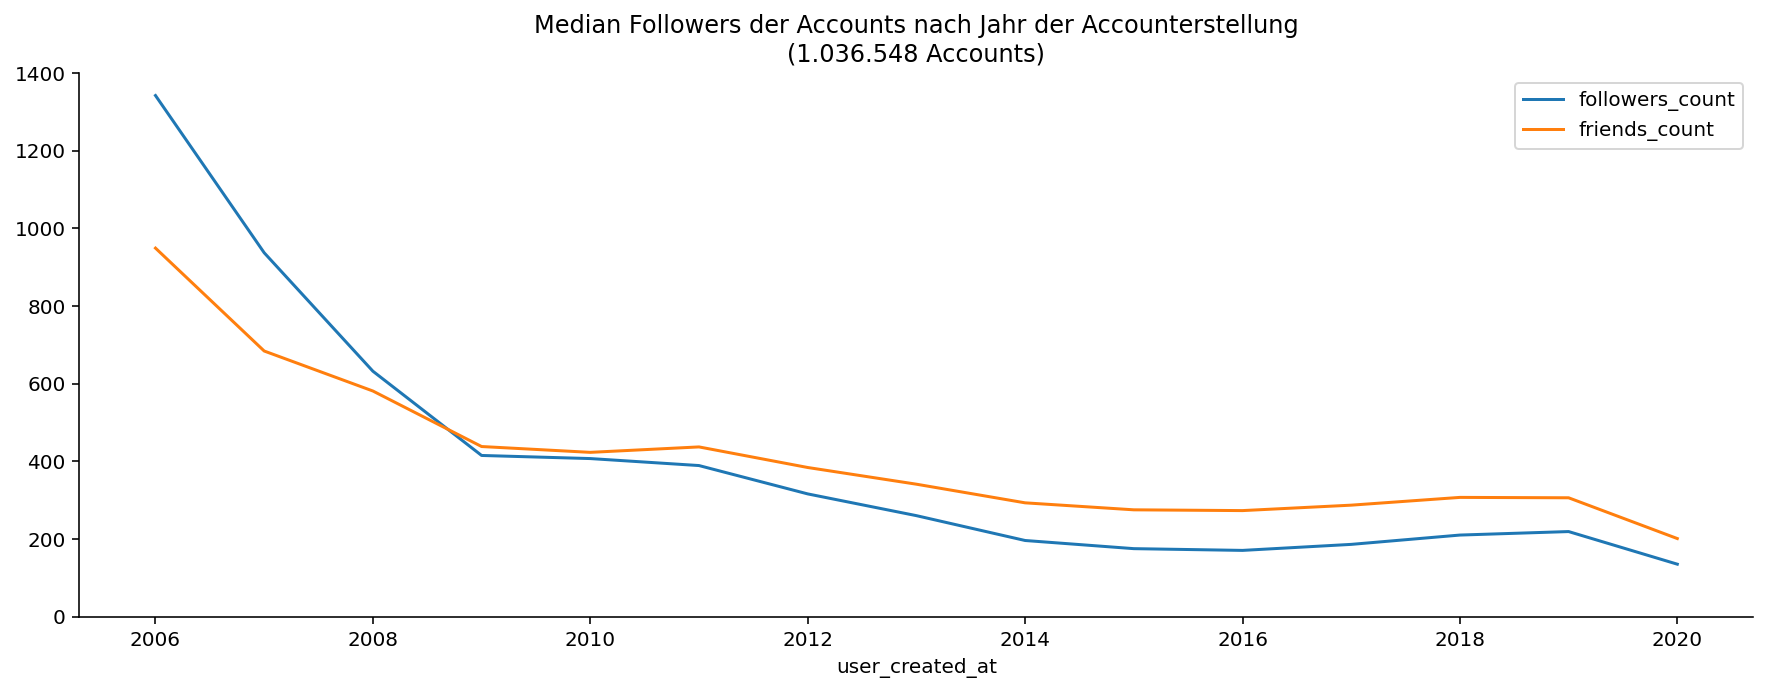

In [131]:
chart = df_accounts.reset_index().groupby(df_accounts.reset_index()['user_created_at'].dt.year).median()[['followers_count','friends_count']].plot(
    figsize = (15,5),
    title = f"Median Followers und Followings der Accounts nach Jahr der Accounterstellung\n({len(df_accounts):,} Accounts)".replace(',','.')
)
chart.spines['top'].set_visible(False)
chart.spines['right'].set_visible(False)
chart.set_ylim(ymin=0, ymax=1400)

(0.0, 130.0)

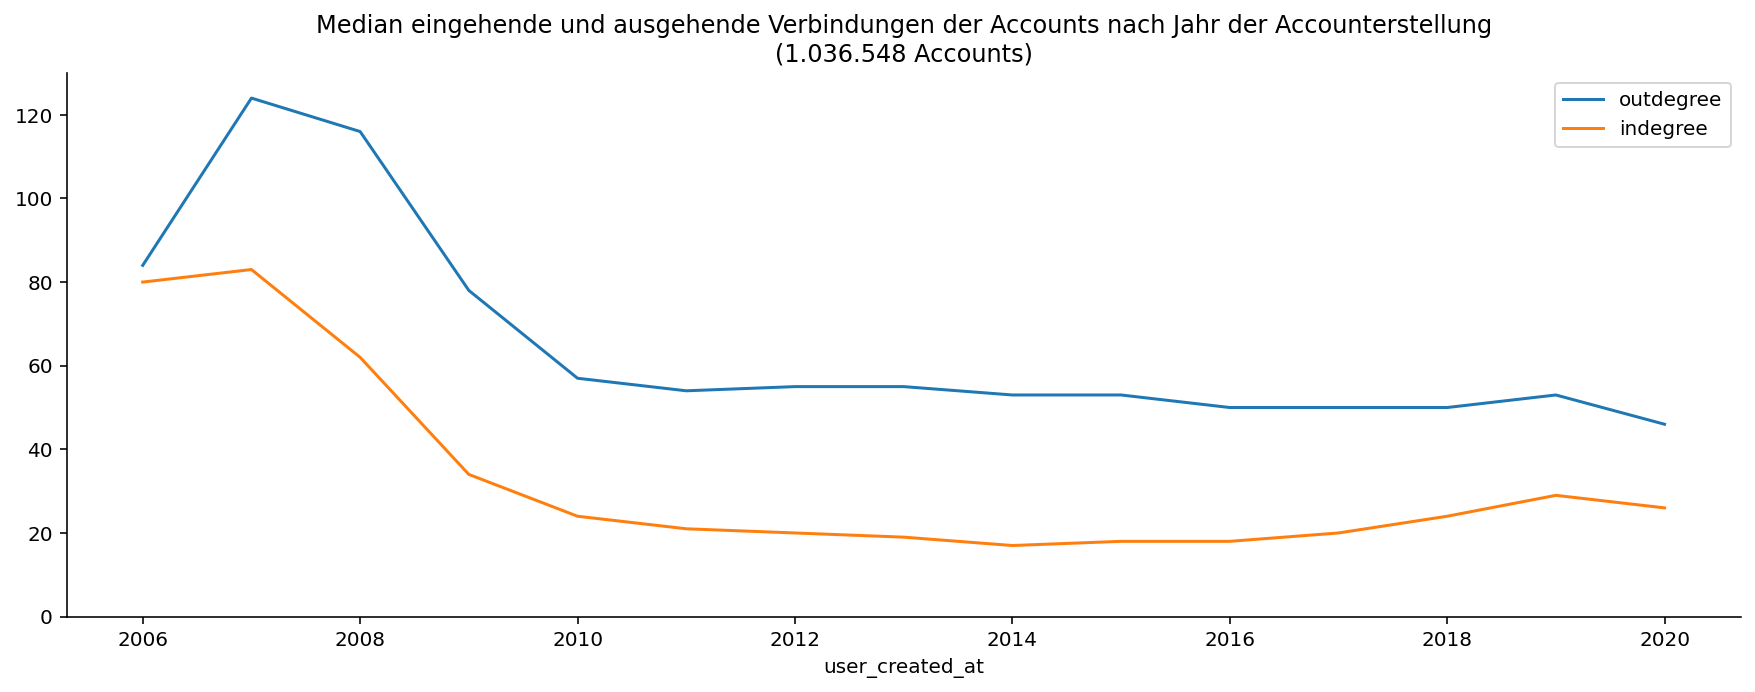

In [137]:
chart = df_accounts.reset_index().groupby(df_accounts.reset_index()['user_created_at'].dt.year).median()[['outdegree','indegree']].plot(
    figsize = (15,5),
    title = f"Median eingehende und ausgehende Verbindungen der Accounts nach Jahr der Accounterstellung\n({len(df_accounts):,} Accounts)".replace(',','.')
)
chart.spines['top'].set_visible(False)
chart.spines['right'].set_visible(False)
chart.set_ylim(ymin=0, ymax=130)

In [139]:
# Statistik
print(
    f"Indegree Mean: {df_accounts['indegree'].mean()}\n",
    f"Indegree Median: {df_accounts['indegree'].median()}\n",
    f"Outdegree Mean: {df_accounts['outdegree'].mean()}\n",
    f"Outdegree Median: {df_accounts['outdegree'].median()}\n",
)


Indegree Mean: 115.58740260943053
 Indegree Median: 24.0
 Outdegree Mean: 115.58730227640206
 Outdegree Median: 52.0



In [160]:
df_accounts['indegree_zu_follow'] = (df_accounts['indegree']/df_accounts['followers_count'])

/home/luca/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [183]:
df_accounts[['screen_name','indegree','followers_count','indegree_zu_follow']].sort_values(by='indegree', ascending=False).head(50)

,screen_name,indegree,followers_count,indegree_zu_follow
user_created_at,,,,
2009-01-16 15:55:55,janboehm,105185,2200536,0.047800
2014-10-04 10:50:34,c_drosten,102633,504238,0.203541
2007-05-03 08:42:42,tagesschau,97915,2781550,0.035202
2010-01-16 18:23:48,Der_Postillon,92300,1047205,0.088139
2014-09-26 11:36:23,heuteshow,87707,1053480,0.083255
2007-05-02 15:17:01,zeitonline,81009,2252652,0.035962
2007-03-29 12:54:46,derspiegel,79033,2676926,0.029524
2010-02-15 17:10:14,SZ,71032,1642247,0.043253
2008-10-14 20:46:08,extra3,67400,911414,0.073951


In [190]:
df_accounts[df_accounts['indegree_zu_follow'] >= 0.4][['screen_name','indegree','followers_count','indegree_zu_follow']].sort_values(by='indegree', ascending=False).head(50)

,screen_name,indegree,followers_count,indegree_zu_follow
user_created_at,,,,
2009-04-27 20:14:30,Natascha_Strobl,41701,100378,0.415440
2015-12-18 20:06:46,ebonyplusirony,26632,60852,0.437652
2018-06-11 17:31:41,stephanpalagan,25376,52303,0.485173
2015-03-14 21:28:19,polenz_r,23690,54478,0.434854
2011-10-22 11:45:52,kattascha,20120,48877,0.411646
2009-04-30 17:05:59,reitschuster,19068,44322,0.430215
2010-04-23 13:56:42,vonDobrowolski,17980,35802,0.502207
2015-02-18 18:52:54,drluebbers,16852,36696,0.459233
2018-05-29 21:47:01,ApothekerDer,16633,34320,0.484645


In [197]:
df_accounts[df_accounts['friends_count'] >  5000]

,user_id,screen_name,followers_count,friends_count,is_verified,study_tweet_counts,indegree,outdegree,Degree,indegree_zu_follow
user_created_at,,,,,,,,,,
2006-07-14 05:49:14,767,xeni,155087,15313,True,8,1406,0,1406,0.009066
2006-08-22 19:18:05,4602,planspark,3376,5002,False,6,160,0,160,0.047393
2006-09-04 13:56:56,5267,alper,4664,7102,True,37,295,0,295,0.063250
2006-11-18 00:54:23,12912,maura,24171,5600,False,5,119,0,119,0.004923
2006-11-22 15:37:44,15383,JahFurry,4149,5001,False,6,25,0,25,0.006026
...,...,...,...,...,...,...,...,...,...,...
2020-09-08 17:15:36,1303381453808435202,terbcot,5892,5650,False,6,757,0,757,0.128479
2020-09-10 12:30:54,1304034582065491971,xswnju,2236,5002,False,4,152,0,152,0.067979
2020-09-11 18:15:25,1304483648306122755,ahbebusraaa,5449,5001,False,13,153,0,153,0.028079


In [9]:
df_accounts.sort_values(by='study_tweet_counts')

,user_id,screen_name,followers_count,friends_count,is_verified,study_tweet_counts,indegree,outdegree,Degree
user_created_at,,,,,,,,,
2018-05-02 11:41:49,991643923536908288,NoWay_4You_Olli,0,76,False,4,0,35,35
2017-12-11 08:32:58,940137318790418432,LifeofTence,9,28,False,4,9,24,33
2017-12-11 08:01:53,940129496568442881,yjhfairy,488,131,False,4,44,30,74
2017-12-11 05:52:05,940096832167862272,BrightWin_55555,162,470,False,4,1,5,6
2017-12-11 05:11:16,940086558538924032,JakeXArsenal,25,279,False,4,0,7,7
...,...,...,...,...,...,...,...,...,...
2017-01-09 04:30:42,818314028099530756,GermanTwitchRT,5531,2071,False,15945,1948,551,2499
2019-12-07 17:34:14,1203367103606210560,GermanYoutuber2,2045,1,False,16096,932,1,933
2019-10-08 13:04:05,1181555830073757704,germantwitchSUP,4207,1,False,26411,2066,1,2067
